In [1]:
import warnings
warnings.filterwarnings('ignore')
import Bio
from Bio.Data import CodonTable
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import os

In [2]:
selection_val_dir = '../analysis/selection_values/'
output_dir = '../analysis/output_figures/'

In [3]:
# Read in amino acid level selection value dfs (with selection values calculated by summing bc counts across transfections)
rep7868_selection_aa_trans_df = pd.read_csv(selection_val_dir + 'rep7868_selection_values_aa_trans.csv',
                                      header=[0], index_col=[0,1,2,3], skipinitialspace=True)
wtaav2_selection_aa_trans_df = pd.read_csv(selection_val_dir + 'wtaav2_selection_values_aa_trans.csv',
                                     header=[0], index_col=[0,1,2,3], skipinitialspace=True)
aav5_selection_aa_trans_df = pd.read_csv(selection_val_dir + 'aav5_selection_values_aa_trans.csv',
                                   header=[0], index_col=[0,1,2,3], skipinitialspace=True)
aav9_selection_aa_trans_df = pd.read_csv(selection_val_dir + 'aav9_selection_values_aa_trans.csv',
                                   header=[0], index_col=[0,1,2,3], skipinitialspace=True)
aav5_selection_aa_trans_df.head()

virus
abs_pos aa is_wt_aa lib_type          
1       *  0        del       0.760313
                    sub       0.730094
        A  0        sub       0.734126
        C  0        sub       0.670787
        D  0        sub       1.044962

In [4]:
# Read in codon level selection value dfs (with selection values calculated by summing bc counts across transfections)
rep7868_selection_codon_trans_df = pd.read_csv(selection_val_dir + 'rep7868_selection_values_codon_trans.csv',
                                      header=[0], index_col=[0,1,2,3,4,5], skipinitialspace=True)
wtaav2_selection_codon_trans_df = pd.read_csv(selection_val_dir + 'wtaav2_selection_values_codon_trans.csv',
                                     header=[0], index_col=[0,1,2,3,4,5], skipinitialspace=True)
aav5_selection_codon_trans_df = pd.read_csv(selection_val_dir + 'aav5_selection_values_codon_trans.csv',
                                   header=[0], index_col=[0,1,2,3,4,5], skipinitialspace=True)
aav9_selection_codon_trans_df = pd.read_csv(selection_val_dir + 'aav9_selection_values_codon_trans.csv',
                                   header=[0], index_col=[0,1,2,3,4,5], skipinitialspace=True)
aav5_selection_codon_trans_df.head()

virus
abs_pos aa codon aa-codon lib_type is_wt          
1       *  TAA   *-TAA    del      0      0.752998
                          sub      0      1.009754
           TAG   *-TAG    sub      0      0.450101
           TGA   *-TGA    sub      0      0.541247
        A  GCA   A-GCA    sub      0      0.745461

In [5]:
def save_fig(fig, fig_name, directory, transparent=True):
    fig_path = os.path.join(directory, fig_name)
    fig.savefig(fig_path, bbox_inches='tight', dpi='figure',transparent=transparent)

In [35]:
DESIRED_AA_COD_ORD = ["I-ATA", "I-ATC", "I-ATT", "L-CTA", "L-CTC", "L-CTG", "L-CTT", "L-TTA", "L-TTG", "V-GTA", "V-GTC", "V-GTG", "V-GTT", "A-GCA", "A-GCC", "A-GCG", "A-GCT", "G-GGA", "G-GGC", "G-GGG", "G-GGT", "M-ATG", "F-TTC", "F-TTT", "Y-TAC", "Y-TAT", "W-TGG", "E-GAA", "E-GAG", "D-GAC", "D-GAT", "Q-CAA", "Q-CAG", "N-AAC", "N-AAT", "H-CAC", "H-CAT", "C-TGC", "C-TGT", "R-AGA", "R-AGG", "R-CGA", "R-CGC", "R-CGG", "R-CGT", "K-AAA", "K-AAG", "S-AGC", "S-AGT", "S-TCA", "S-TCC", "S-TCG", "S-TCT", "T-ACA", "T-ACC", "T-ACG", "T-ACT", "P-CCA", "P-CCC", "P-CCG", "P-CCT", "*-TAA", "*-TAG", "*-TGA"]
DESIRED_AA_ORD = ["I", "L", "V", "A", "G", "M", "F", "Y", "W", "E", "D", "Q", "N", "H", "C", "R", "K", "S", "T", "P", "*"]


def plot_heatmap(selection_matrix,
                 lib_type='sub', 
                 save_dir=output_dir, 
                 range_in=None,
                 fig_dimensions=[8,2],
                 dot_size=1,
                 text_size=7,
                 tick_size=.5,
                 plot_white=False,
                 line_width = .5,
                 min_max = (-5,5),
                 return_df = False,
                 save=False,
                 plt_cbar=False,
                 save_name=None):
    
    selection_matrix = selection_matrix.apply(np.log2)
    level ='aa-codon' if 'aa-codon' in selection_matrix.index.names else 'aa'
#     print (level)
    order = DESIRED_AA_COD_ORD if level == 'aa-codon' else DESIRED_AA_ORD
#     is_wt = 'is_wt_codon' if level == 'aa-codon' else 'is_wt_aa'
    is_wt = 'is_wt'
    
    if range_in is not None:
        selection_matrix = selection_matrix.loc[range_in]
    if level == 'aa-codon':
        df_heatmap_ready = selection_matrix.xs(
            lib_type, level='lib_type', drop_level=False ).reset_index(level=is_wt, drop=True).unstack(0).reset_index(
                level=[0,1],drop=True).reindex(DESIRED_AA_COD_ORD,level='aa-codon')
        df_heatmap_ready.index = df_heatmap_ready.index.droplevel(1)
    else:
        df_heatmap_ready = selection_matrix.xs(lib_type, level='lib_type',drop_level=False ).groupby(level=['aa', 'lib_type','abs_pos']).mean().unstack(
            'abs_pos').reset_index(level=1, drop=1).reindex(DESIRED_AA_ORD)
    
    if plot_white:
        df_heatmap_ready[:] = 0
    
    if range_in is not None:
        wt_plot_use = WT_PLOTTING_DF[WT_PLOTTING_DF['abs_pos'].isin(range_in)]
    else:
        wt_plot_use = WT_PLOTTING_DF
   
    #wt_plot_use['aa-codon'] = wt_plot_use['aa'] + '-' + wt_plot_use['codon']
    wt_plot_use['aa-codon'] = wt_plot_use.apply(lambda row: row.aa + '-' + row.codon, axis=1)
    mat_wt = wt_plot_use[wt_plot_use['wt']==1].pivot(index=level, columns='abs_pos', values='wt').reindex(order)
    
    if level == 'aa-codon':
        line_splits=[]
        for idx,letter in enumerate(DESIRED_AA_COD_ORD):
            aa = letter.split('-')[0]
            aa_previous = DESIRED_AA_COD_ORD[idx-1].split('-')[0]
            if idx ==0: continue 
            if aa == aa_previous: 
                continue
                print (aa, aa_previous)
            if aa != aa_previous: 
                line_splits.append(idx)
    
    fig_length = 15 if level == 'aa' else 30
    if fig_dimensions:
        fig_params = fig_dimensions
    else:
        fig_params = [120, fig_length] 
    f,(ax1,ax2) = plt.subplots(
        1,2, sharex='col', figsize=fig_dimensions,gridspec_kw = {'width_ratios' : [100,.01],
                                                          'wspace':0.000025, 
                                                          'hspace':0.00005})
    ax1.set_facecolor('white')
    ax2.set_facecolor('white')
#     ax1.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    ax2.get_xaxis().set_visible(False)
    ax2.set_ylim([-64,0])
    ax2.set_xlim([-.5,.5])
#     sns.set(font_scale=.75)
    
    kwargs = {'xticklabels':df_heatmap_ready.columns.get_level_values(1)}
    
#     redblue_cmap = sns.diverging_palette(h_neg=350, h_pos=15, s=75, l=50, sep=3, as_cmap=True)
    lscmap = LinearSegmentedColormap.from_list(name='test', colors=['black','white','firebrick'])
    divnorm = TwoSlopeNorm(vmin=min_max[0], vcenter=0, vmax=min_max[1])
    
    if plt_cbar:
        sns.heatmap(df_heatmap_ready, cmap=lscmap, norm=divnorm, 
            yticklabels=order, cbar=True, ax=ax1, **kwargs)
    else:
        sns.heatmap(df_heatmap_ready, cmap=lscmap, norm=divnorm, 
            yticklabels=order, cbar=False, ax=ax1, **kwargs)
  
    if range_in is None:
        ax1.xaxis.set_major_locator(ticker.MultipleLocator(20))
        ax1.xaxis.set_major_formatter(ticker.ScalarFormatter())

    ax1.tick_params(labelsize=tick_size,length=.5,width=.1,pad=.01, rotation=0)
#     ax1.tick_params(axis='x', rotation=90)
    ax1.set_ylabel('')
    ax1.set_xlabel('')
#     new_xticks = ax1.get_xticks() + 0.5
    ax1.set_xticklabels(range_in, size = text_size, rotation=90)
    ax1.set_yticklabels(order, size = text_size)

    lm = mat_wt.fillna(0).to_numpy()
    x,y = np.nonzero(lm.T)
    ax1.scatter(x+.4,y+.5, color='black', s=dot_size)
    if level == 'aa': sns.set(font_scale=.1)
    if level == 'aa-codon':
#         print ('level is aa-codon')
        for line_pos in line_splits:
            ax1.plot([0,735],[line_pos,line_pos],linewidth=line_width,color='black')
        for line_pos,aa in zip(line_splits,DESIRED_AA_ORD):
            position = -line_pos +1
            if aa == 'C': position += 1
            if aa == 'G': position +=1 if lib_type == 'sub' else 0
            if aa == 'M': position += -1 if lib_type == 'sub' else -2
            if aa == 'F': position += -.5 if lib_type == 'sub' else -1.5
            if aa == 'W': position += -1 if lib_type == 'sub' else -2
            if aa == 'Y': position += -.5 if lib_type == 'sub' else -1.5
            if aa == 'E': position += -.5 if lib_type == 'sub' else -2
            if aa == 'D': position += -.5 if lib_type == 'sub' else -2
            if aa == 'Q': position += -.5 if lib_type == 'sub' else -2
            if aa == 'N': position += -.5 if lib_type == 'sub' else -2
            if aa == 'H': position += -.5 if lib_type == 'sub' else -2.5
            if aa == 'C': position += - 1.5 if lib_type == 'sub' else -3.5
            if aa == 'R': position += + 2 if lib_type == 'sub' else 0
            if aa == 'K': position += - .5 if lib_type == 'sub' else -3
            if aa == 'S': position += + 2 if lib_type == 'sub' else 0
            if aa == 'T': position += + .5 if lib_type == 'sub' else -2
            if aa == 'P': position += + .5 if lib_type == 'sub' else -3
            if plt_cbar is False:
                ax2.text(0,position,aa,size=text_size,family ='monospace')    
    if save:
        if save_dir:
            if save_name:
                save_fig(f, save_name, save_dir)
            else:
                save_name = os.path.join(save_dir, '%s_%s_%s_%s.pdf'  % (promoter, lib_type, level,lib_num))
                save_fig(f, save_name, save_dir)
    if return_df:
        return {'df_heatmap' : df_heatmap_ready}

In [7]:
# Generate WT_PLOTTING_DF to overlay heatmaps for Rep78/68 libraries
standard_table = CodonTable.unambiguous_dna_by_name["Standard"]
codon_dict = standard_table.forward_table
# Add stop codons
codon_dict['TAA'] = '*'
codon_dict['TAG'] = '*'
codon_dict['TGA'] = '*'
codons = codon_dict.keys()

wt_rep = 'ATGCCGGGGTTTTACGAGATTGTGATTAAGGTCCCCAGCGACCTTGACGAGCATCTGCCCGGCATTTCTGACAGCTTTGTGAACTGGGTGGCCGAGAAGGAATGGGAGTTGCCGCCAGATTCTGACATGGATCTGAATCTGATTGAGCAGGCACCCCTGACCGTGGCCGAGAAGCTGCAGCGCGACTTTCTGACGGAATGGCGCCGTGTGAGTAAGGCCCCGGAGGCTCTTTTCTTTGTGCAATTTGAGAAGGGAGAGAGCTACTTCCACATGCACGTGCTCGTGGAAACCACCGGGGTGAAATCCATGGTTTTGGGACGTTTCCTGAGTCAGATTCGCGAAAAACTGATTCAGAGAATTTACCGCGGGATCGAGCCGACTTTGCCAAACTGGTTCGCGGTCACAAAGACCAGAAATGGCGCCGGAGGCGGGAACAAGGTGGTGGATGAGTGCTACATCCCCAATTACTTGCTCCCCAAAACCCAGCCTGAGCTCCAGTGGGCGTGGACTAATATGGAACAGTATTTAAGCGCCTGTTTGAATCTCACGGAGCGTAAACGGTTGGTGGCGCAGCATCTGACGCACGTGTCGCAGACGCAGGAGCAGAACAAAGAGAATCAGAATCCCAATTCTGATGCGCCGGTGATCAGATCAAAAACTTCAGCCAGGTACGGAGAGCTGGTCGGGTGGCTCGTGGACAAGGGGATTACCTCGGAGAAGCAGTGGATCCAGGAGGACCAGGCCTCATACATCTCCTTCAATGCGGCCTCCAACTCGCGGTCCCAAATCAAGGCTGCCTTGGACAATGCGGGAAAGATTATGAGCCTGACTAAAACCGCCCCCGACTACCTGGTGGGCCAGCAGCCCGTGGAGGACATTTCCAGCAATCGGATTTATAAAATTTTGGAACTAAACGGGTACGATCCCCAATATGCGGCTTCCGTCTTTCTGGGATGGGCCACGAAAAAGTTCGGCAAGAGGAACACCATCTGGCTGTTTGGGCCTGCAACTACCGGCAAGACCAACATCGCGGAGGCCATAGCCCACACTGTGCCCTTCTACGGGTGCGTAAACTGGACCAATGAGAACTTTCCCTTCAACGACTGTGTCGACAAGATGGTGATCTGGTGGGAGGAGGGGAAGATGACCGCCAAGGTCGTGGAGTCGGCCAAAGCCATTCTCGGAGGAAGCAAGGTGCGCGTGGACCAGAAATGCAAGTCCTCGGCCCAGATAGACCCGACTCCCGTGATCGTCACCTCCAACACCAACATGTGCGCCGTGATTGACGGGAACTCAACGACCTTCGAACACCAGCAGCCGTTGCAAGACCGGATGTTCAAATTTGAACTCACCCGCCGTCTGGATCATGACTTTGGGAAGGTCACCAAGCAGGAAGTCAAAGACTTTTTCCGGTGGGCAAAGGATCACGTGGTTGAGGTGGAGCATGAATTCTACGTCAAAAAGGGTGGAGCCAAGAAAAGACCCGCCCCCAGTGACGCAGATATAAGTGAGCCCAAACGGGTGCGCGAGTCAGTTGCGCAGCCATCGACGTCAGACGCGGAAGCTTCGATCAACTACGCAGACAGGTACCAAAACAAATGTTCTCGTCACGTGGGCATGAATCTGATGCTGTTTCCCTGCAGACAATGCGAGAGAATGAATCAGAATTCAAATATCTGCTTCACTCACGGACAGAAAGACTGTTTAGAGTGCTTTCCCGTGTCAGAATCTCAACCCGTTTCTGTCGTCAAAAAGGCGTATCAGAAACTGTGCTACATTCATCATATCATGGGAAAGGTGCCAGACGCTTGCACTGCCTGCGATCTGGTCAATGTGGATTTGGATGACTGCATCTTTGAACAATAAATGATTTAAATCAGGTATGGCTGCCGATGGTTATCTTCCAGATTGGCTCGAGGACACTCTCTCTGA'
WT_PLOTTING_DF = pd.DataFrame(columns=['aa', 'abs_pos', 'codon', 'wt'])
nt = 0
abs_pos = 1
while nt < len(wt_rep) - 3:
#     print (wt_rep[nt:nt+3])
    codon = wt_rep[nt:nt+3]
    aa = codon_dict[codon]
    row_dict = {'aa':[aa], 'abs_pos':[abs_pos], 'codon':[codon], 'wt': [1]}
    new_row = pd.DataFrame(row_dict)
    WT_PLOTTING_DF = pd.concat([WT_PLOTTING_DF, new_row])
#     print (new_row)
    abs_pos += 1
    nt += 3

WT_PLOTTING_DF.head()

,aa,abs_pos,codon,wt
0,M,1,ATG,1
0,P,2,CCG,1
0,G,3,GGG,1
0,F,4,TTT,1
0,Y,5,TAC,1


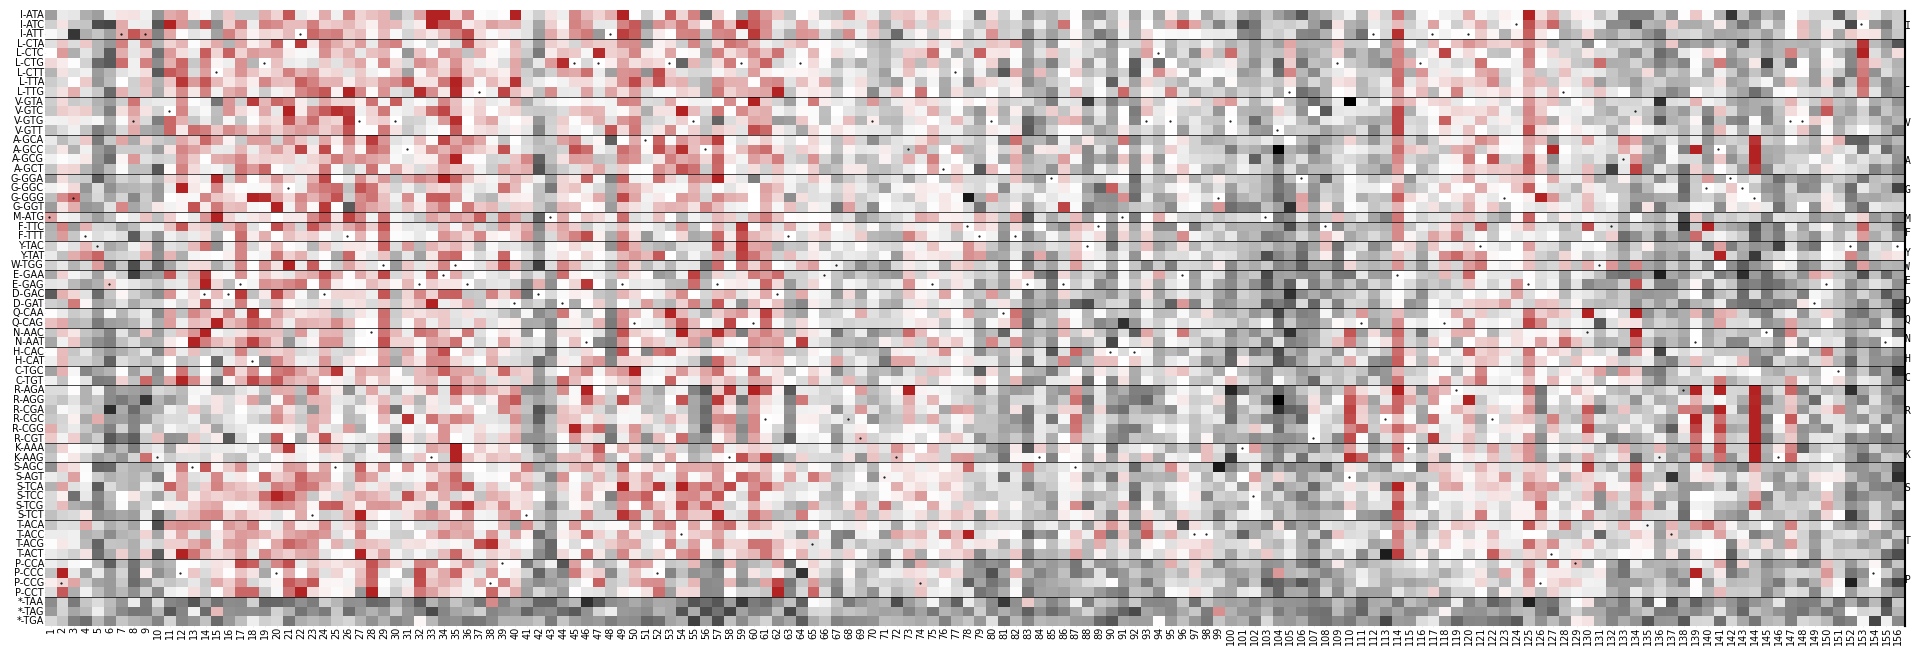

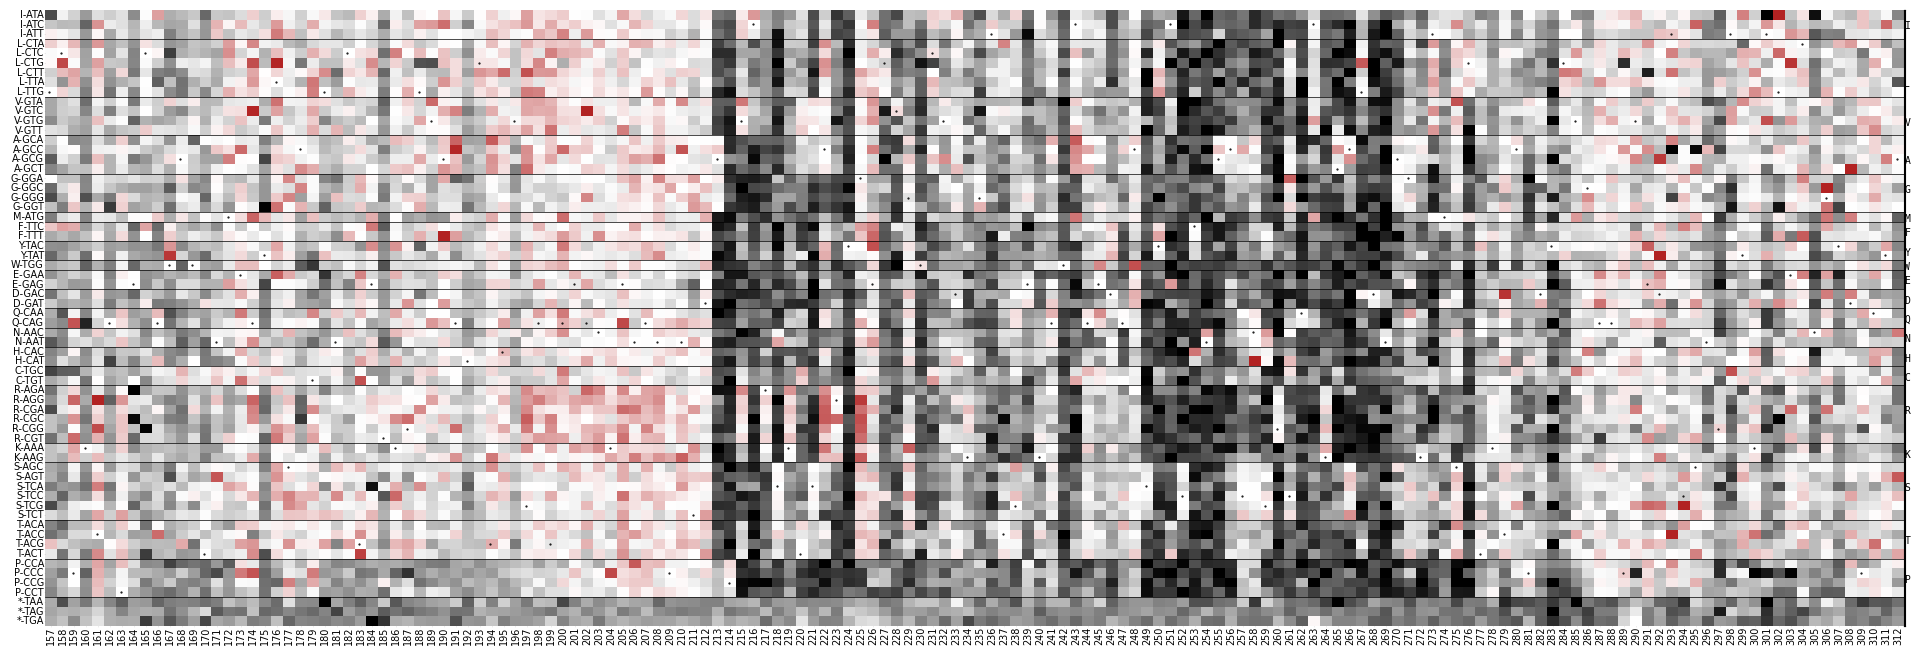

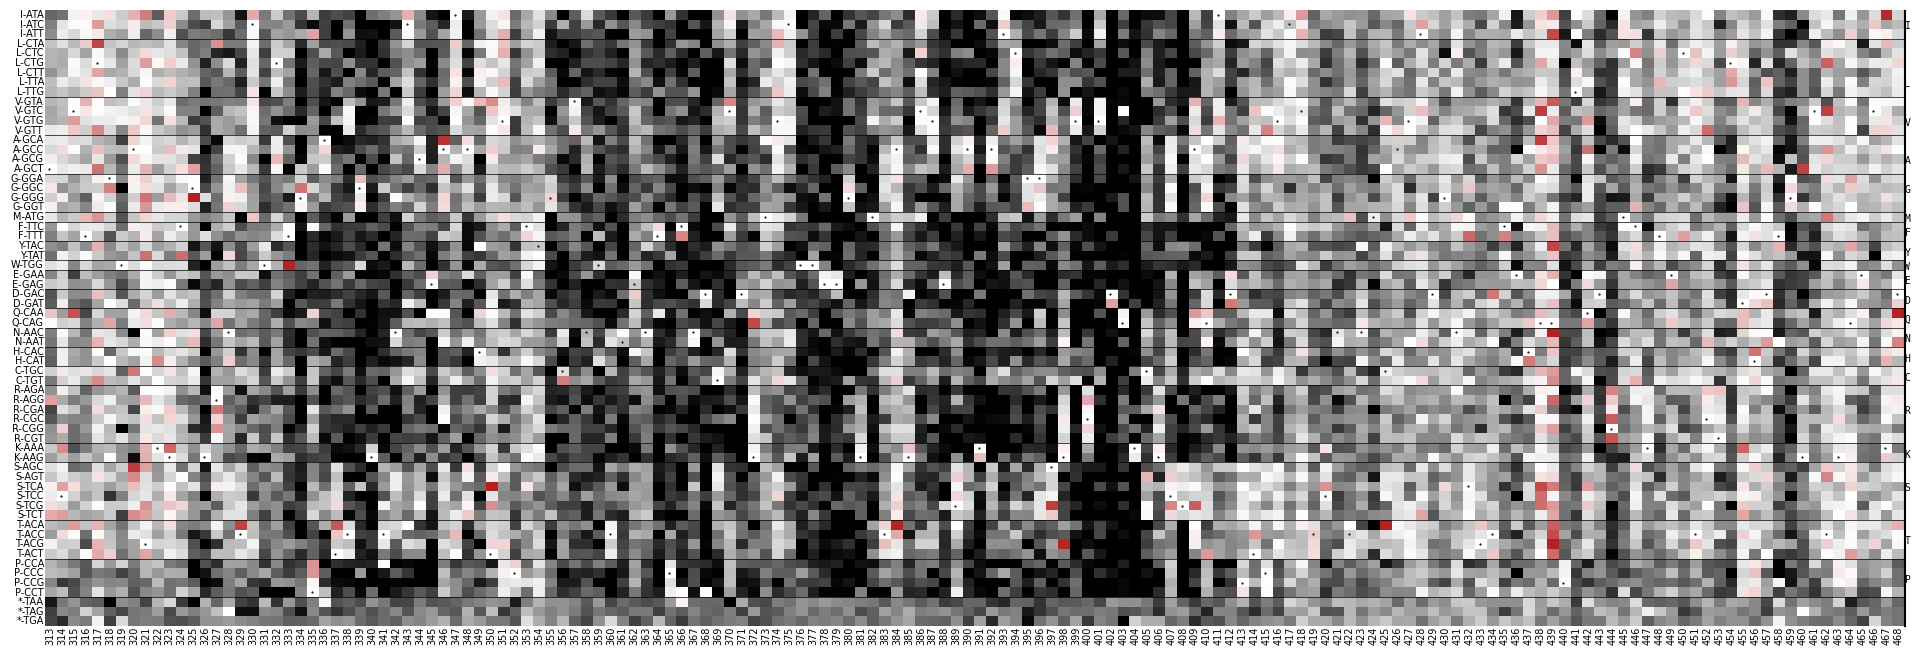

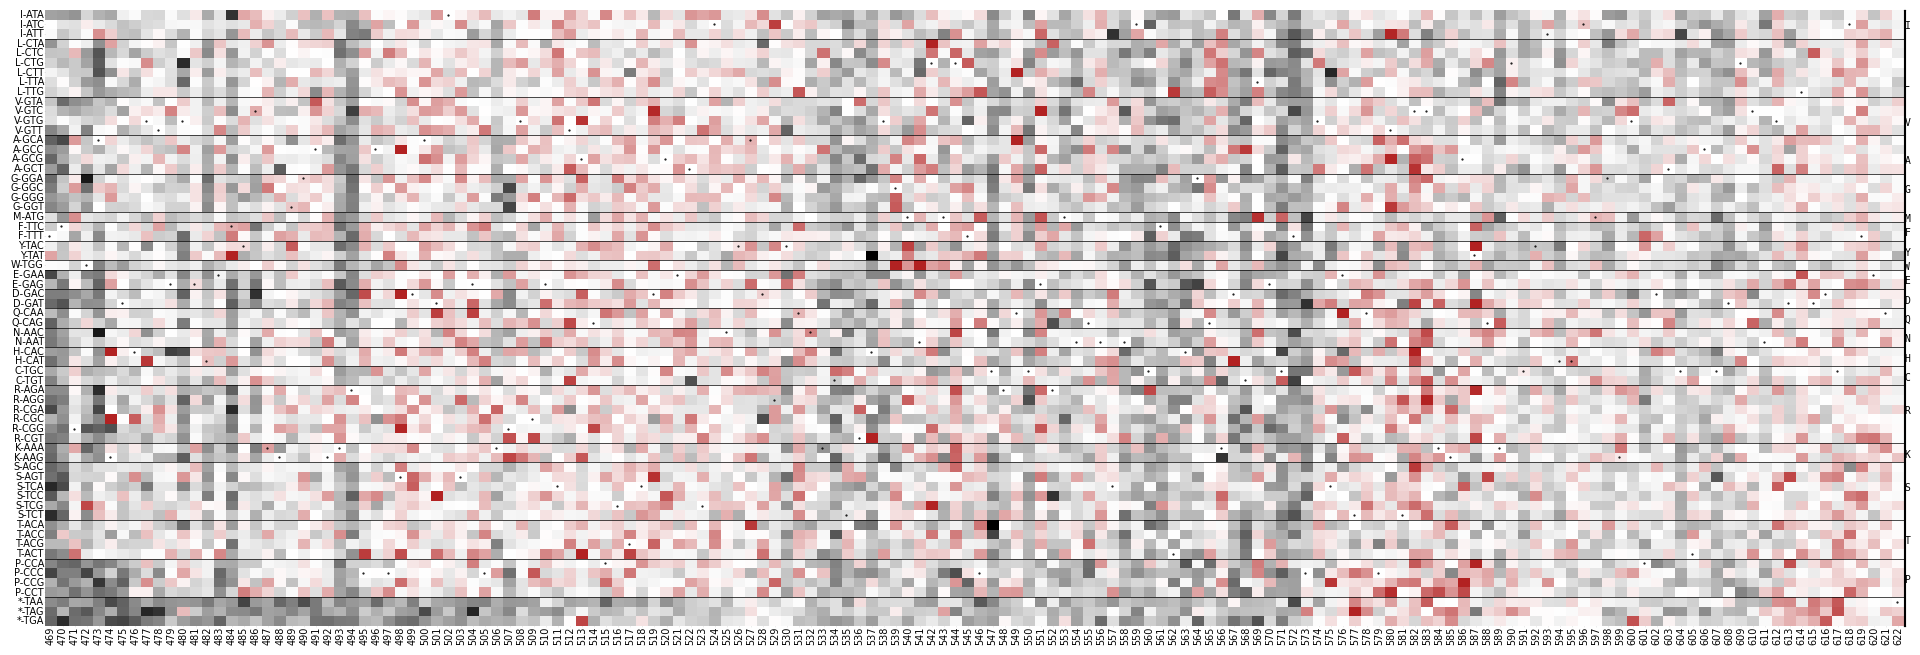

In [12]:
# Make codon level heatmaps using selection values from rep7868 production assay
starting_pos = 1
while starting_pos < 470:
    if starting_pos > 468:
        end_pos = 623
    else:
        end_pos = starting_pos + 156
    plot_heatmap(rep7868_selection_codon_trans_df, range_in=list(range(starting_pos,end_pos)), save=True,
                 save_name='rep7868_codon_level_heatmap_pos' + str(starting_pos) + '-' + str(end_pos) + '.png',
                 dot_size=0.3, fig_dimensions=[24,8], plt_cbar=False, min_max=(-2.5, 1), text_size=7)
    starting_pos += 156

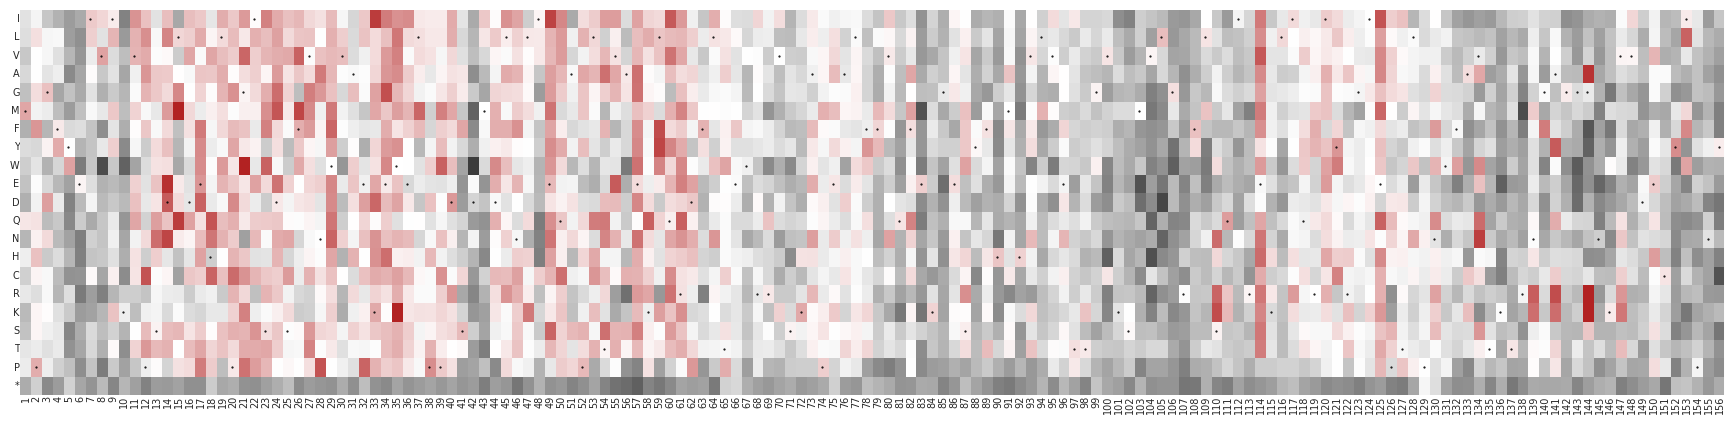

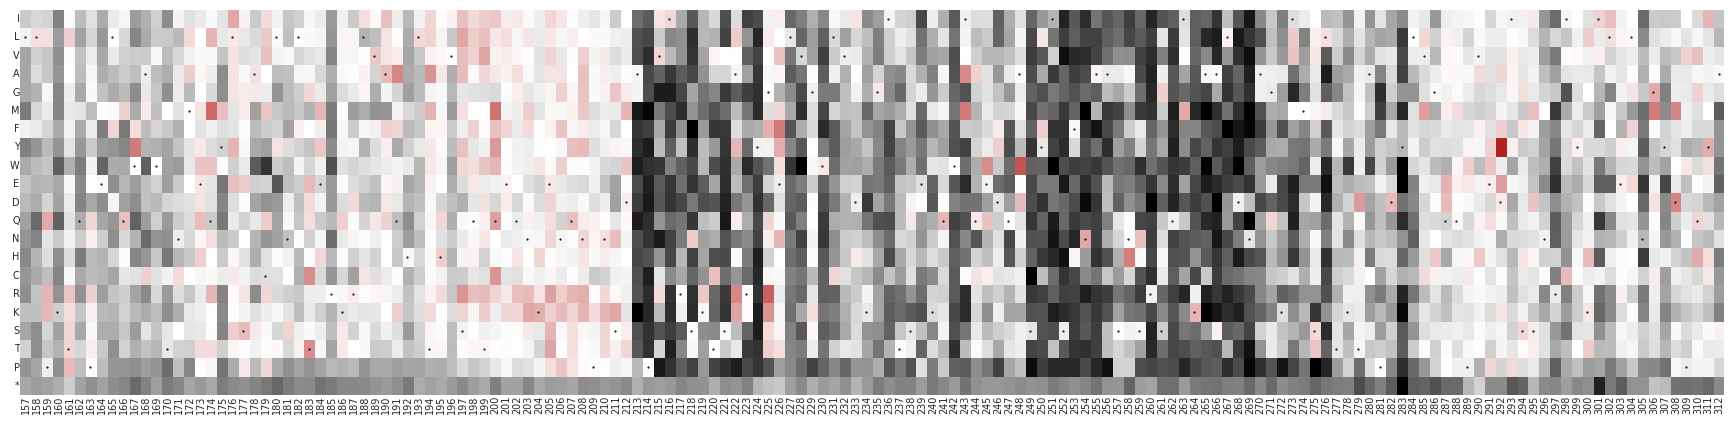

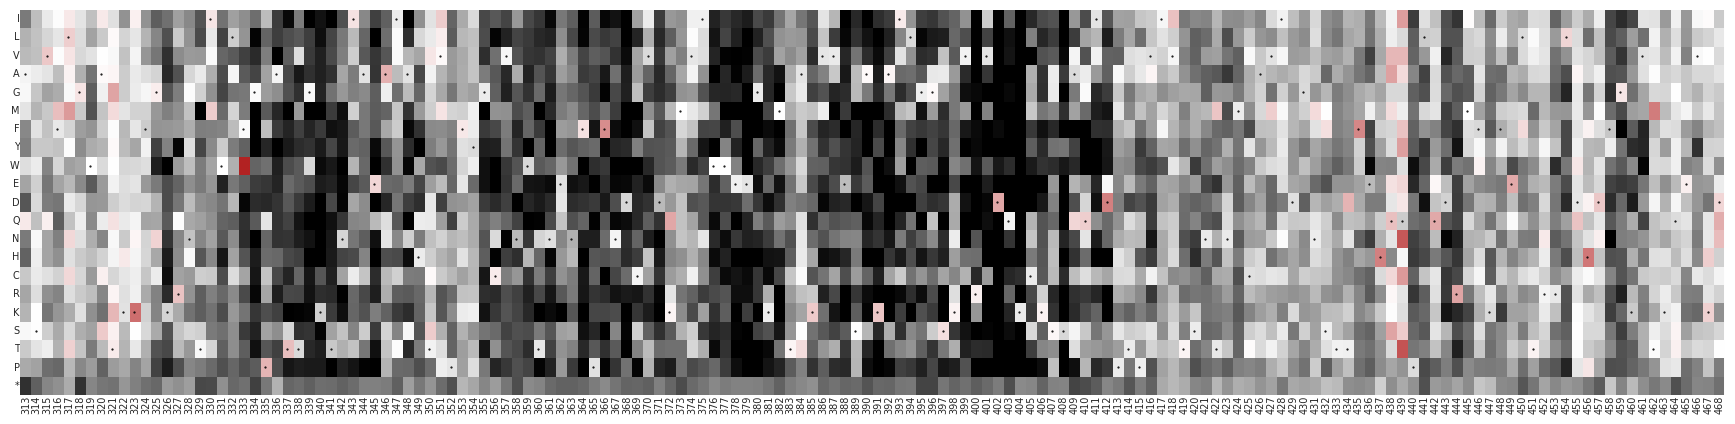

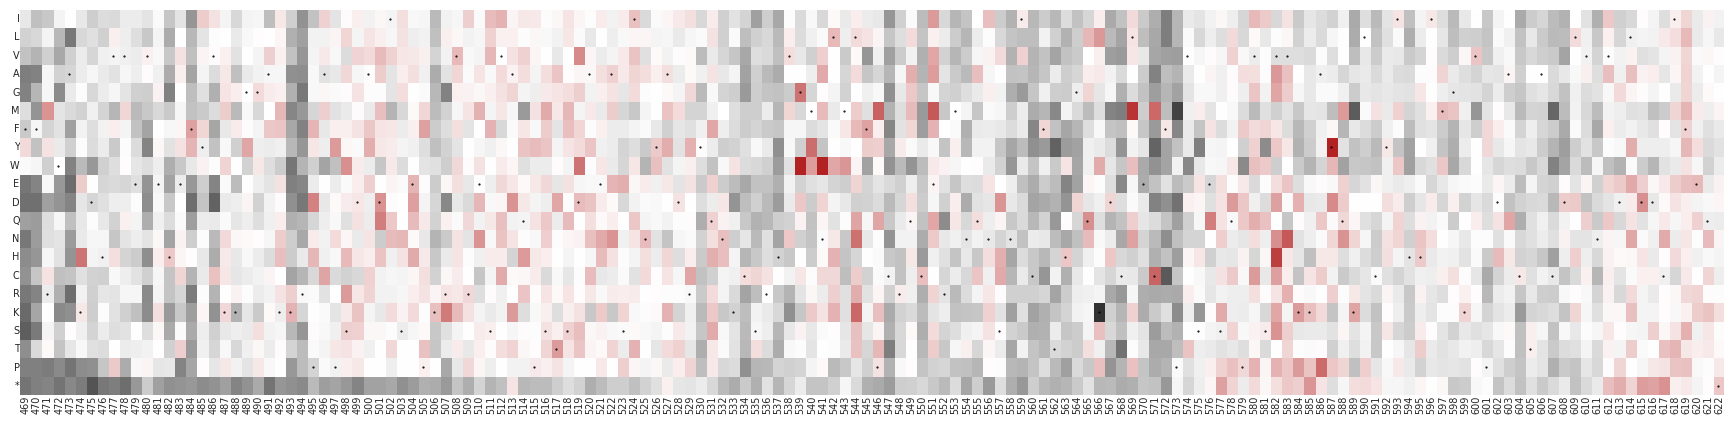

In [15]:
# Make aa level heatmaps using selection values from rep7868 production assay
starting_pos = 1
while starting_pos < 470:
    if starting_pos > 468:
        end_pos = 623
    else:
        end_pos = starting_pos + 156
    plot_heatmap(rep7868_selection_aa_trans_df, range_in=list(range(starting_pos,end_pos)), save=True,
                 save_name='rep7868_aa_level_heatmap_pos' + str(starting_pos) + '-' + str(end_pos) + '.png',
                 dot_size=0.3, fig_dimensions=[22,5], plt_cbar=False, min_max=(-2.5, 1), text_size=7)
    starting_pos += 156

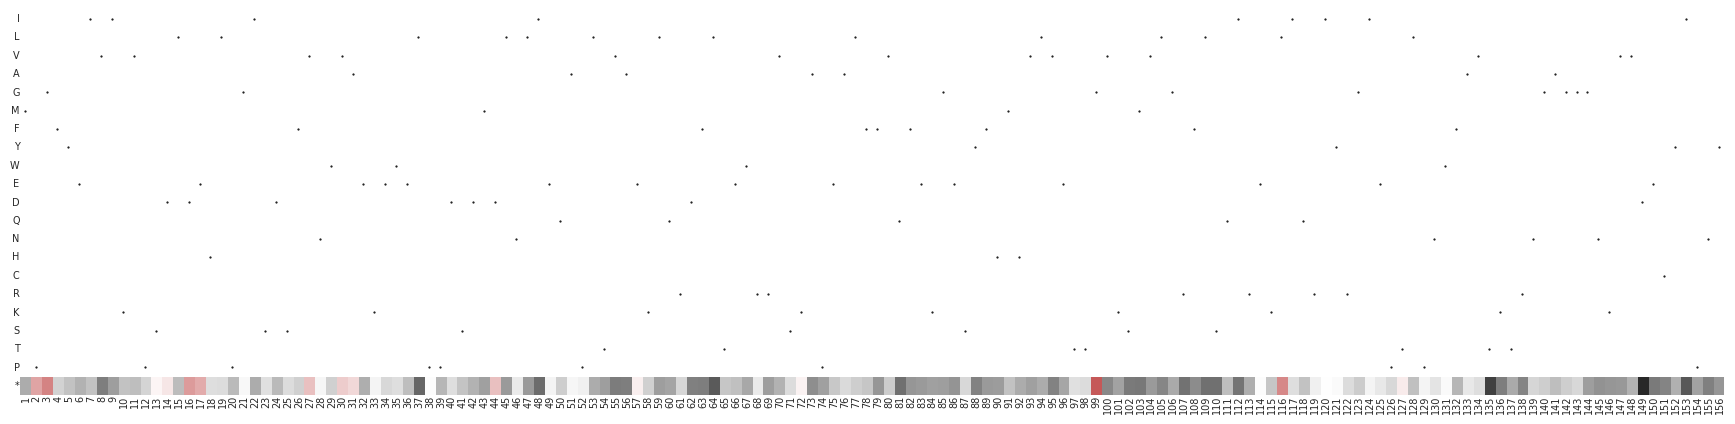

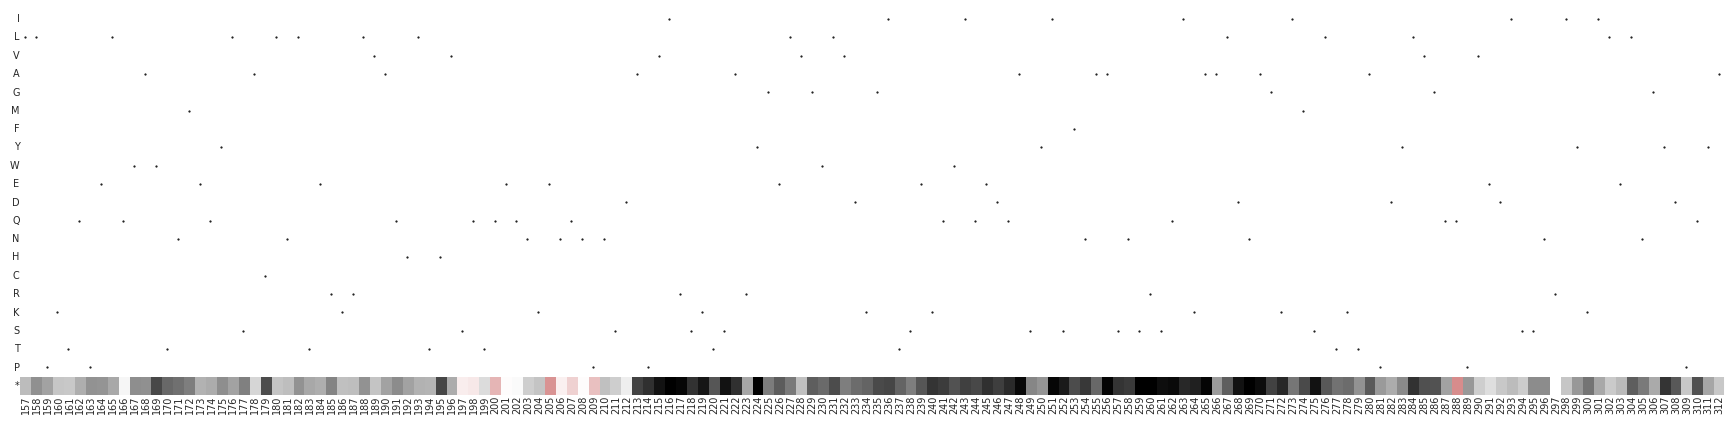

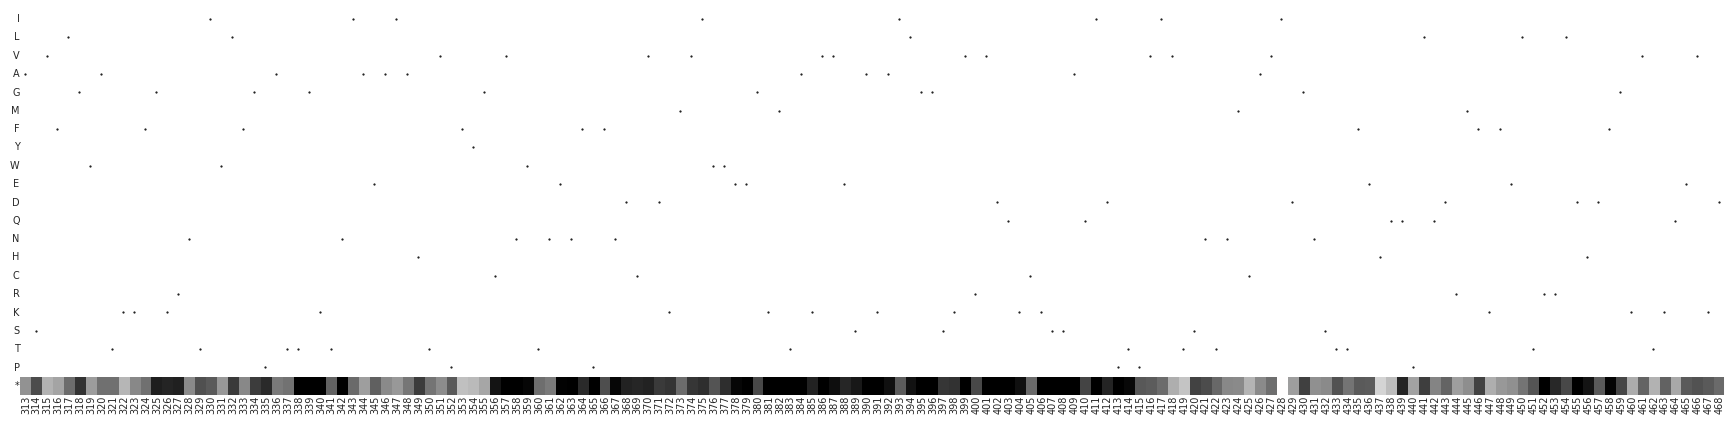

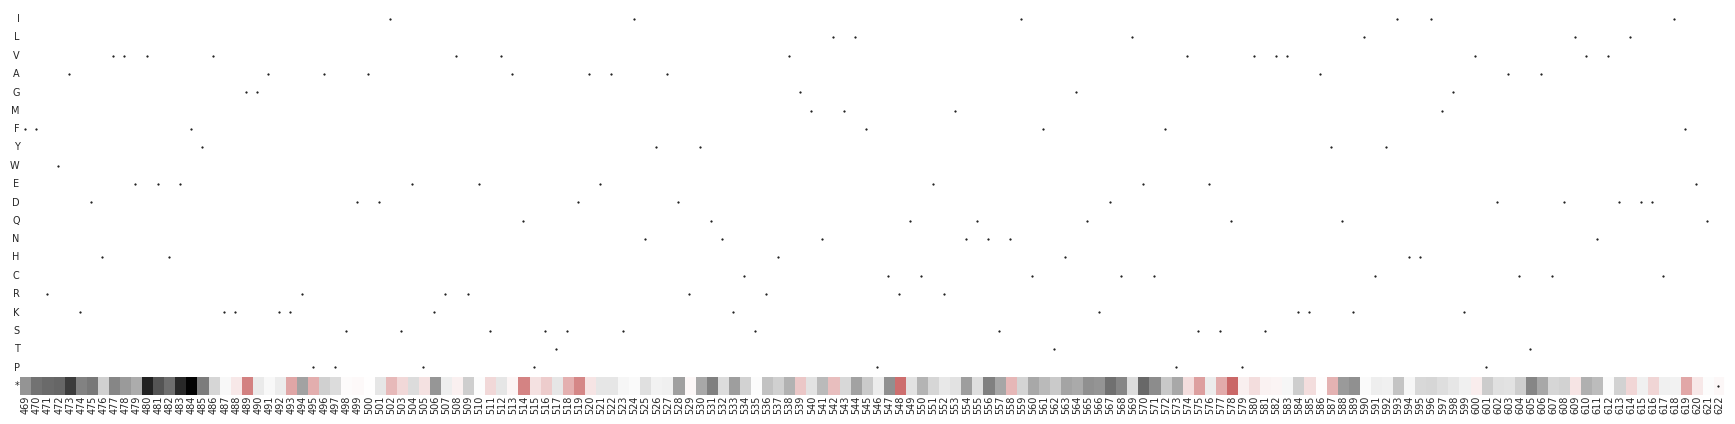

In [16]:
# Make aa level heatmaps using selection values from rep7868 production assay for deletion variants
starting_pos = 1
while starting_pos < 470:
    if starting_pos > 468:
        end_pos = 623
    else:
        end_pos = starting_pos + 156
    plot_heatmap(rep7868_selection_aa_trans_df, range_in=list(range(starting_pos,end_pos)), save=True, lib_type='del',
                 save_name='rep7868_aa_level_heatmap_pos' + str(starting_pos) + '-' + str(end_pos) + '_del.png',
                 dot_size=0.3, fig_dimensions=[22,5], plt_cbar=False, min_max=(-2.5, 1), text_size=7)
    starting_pos += 156

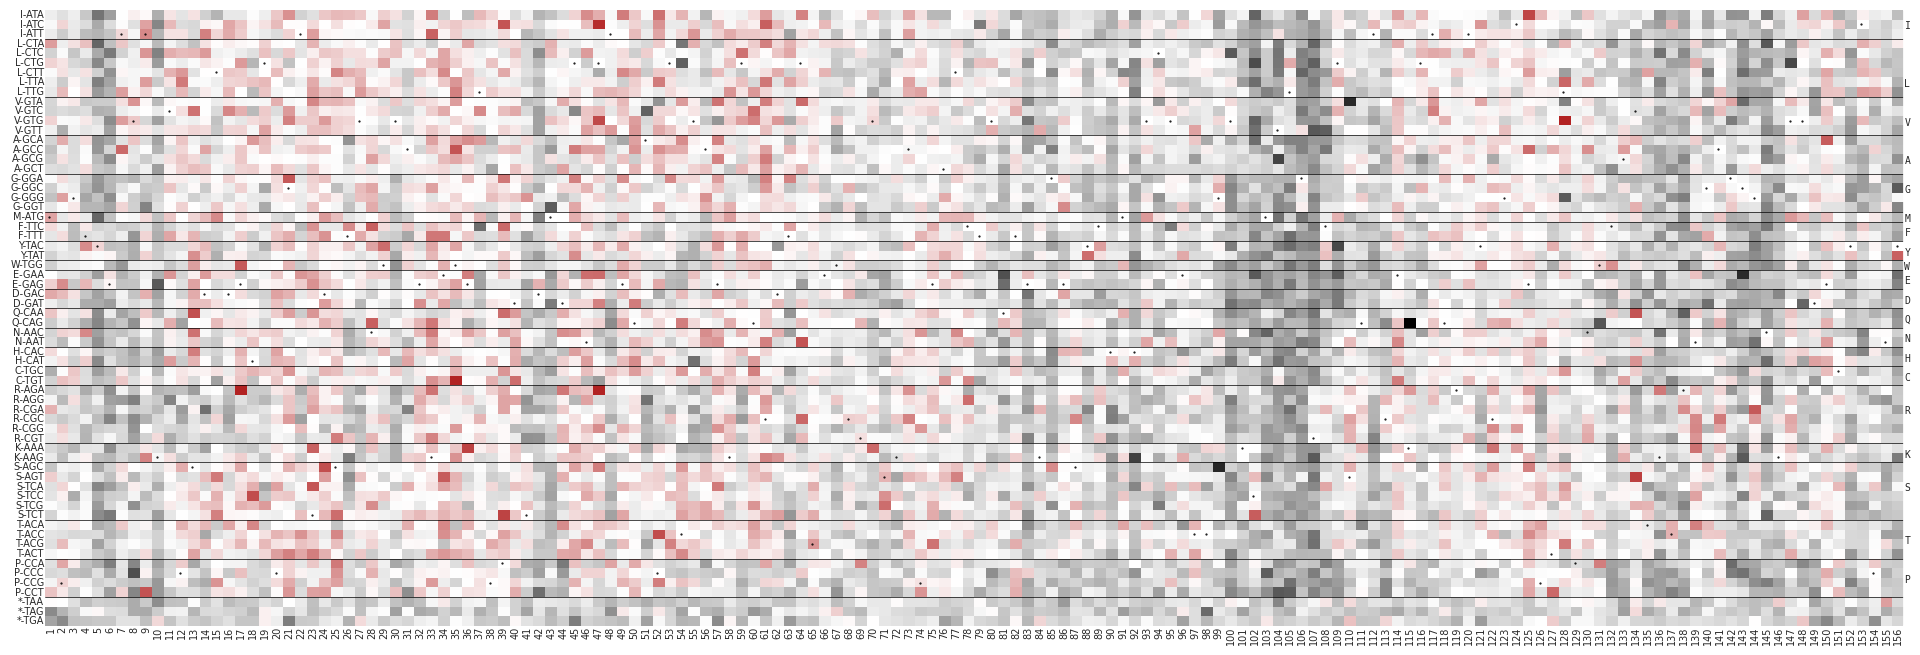

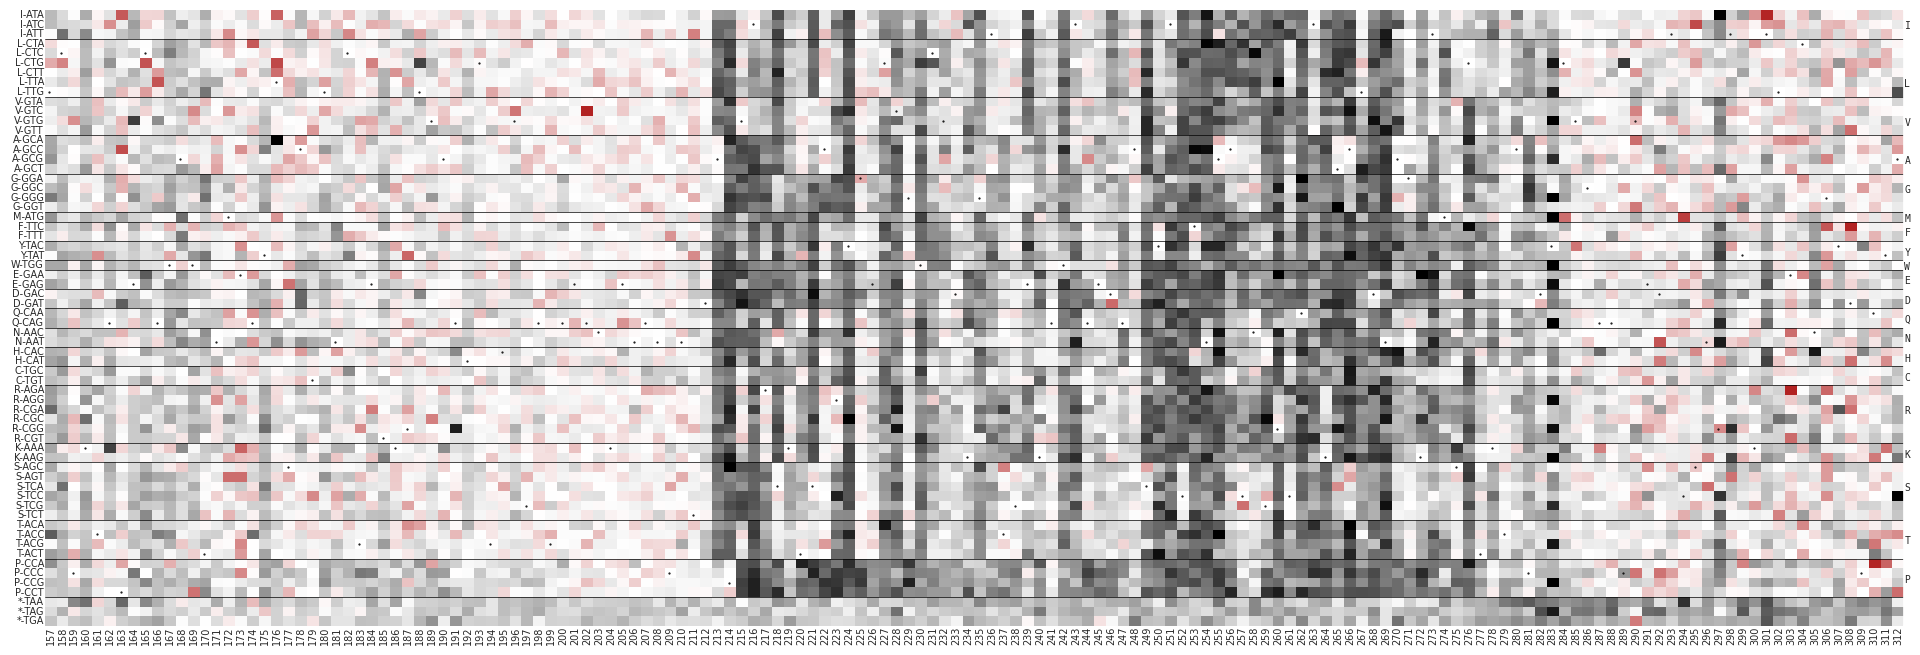

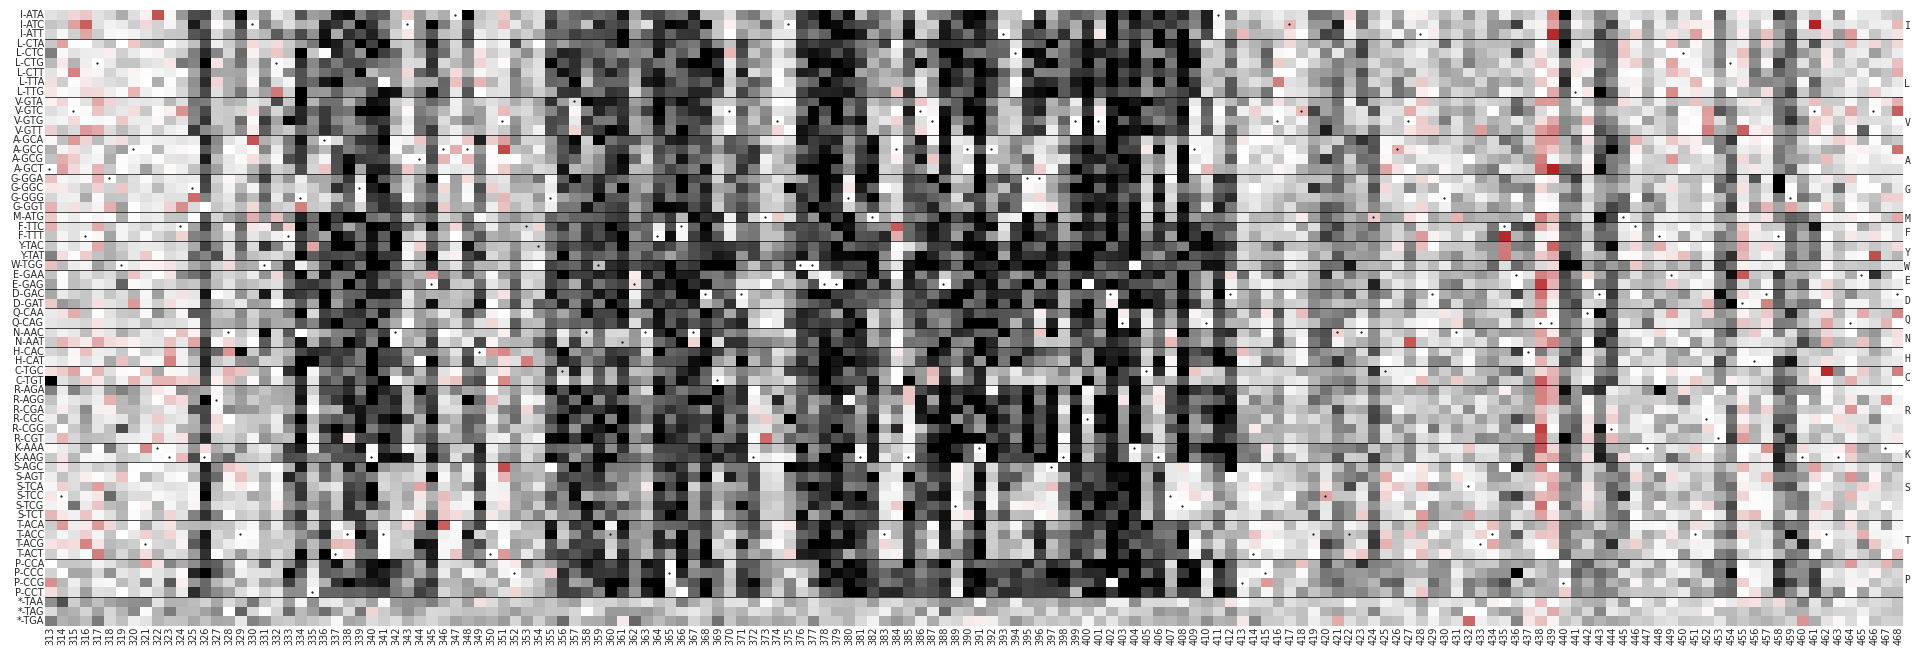

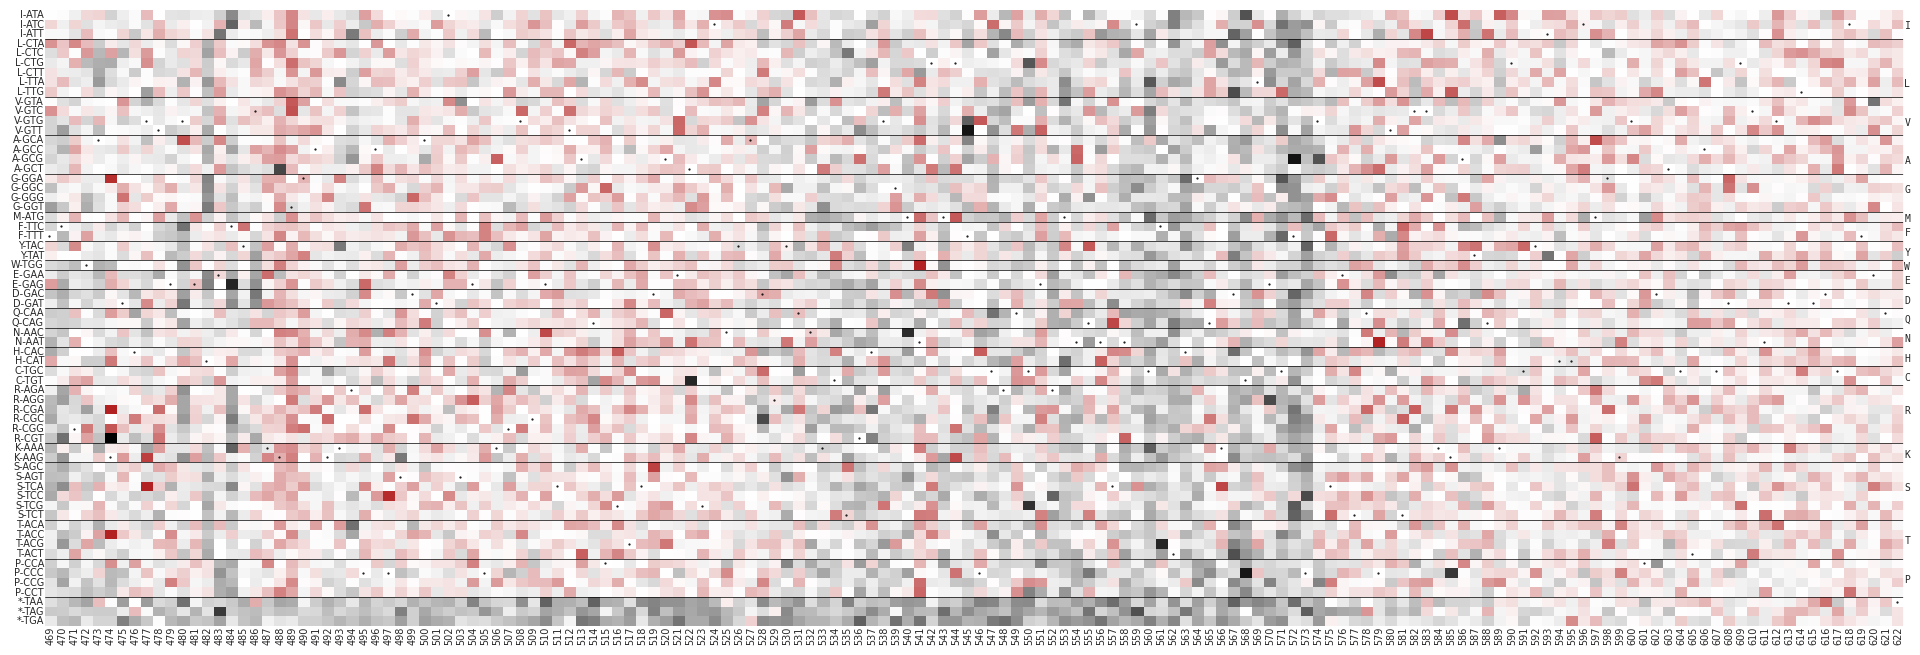

In [17]:
# Make codon level heatmaps using selection values from aav5 production assay
starting_pos = 1
while starting_pos < 470:
    if starting_pos > 468:
        end_pos = 623
    else:
        end_pos = starting_pos + 156
    plot_heatmap(aav5_selection_codon_trans_df, range_in=list(range(starting_pos,end_pos)), save=True,
                 save_name='aav5_codon_level_heatmap_pos' + str(starting_pos) + '-' + str(end_pos) + '.png',
                 dot_size=0.3, fig_dimensions=[24,8], plt_cbar=False, min_max=(-2.5, 1), text_size=7)
    starting_pos += 156

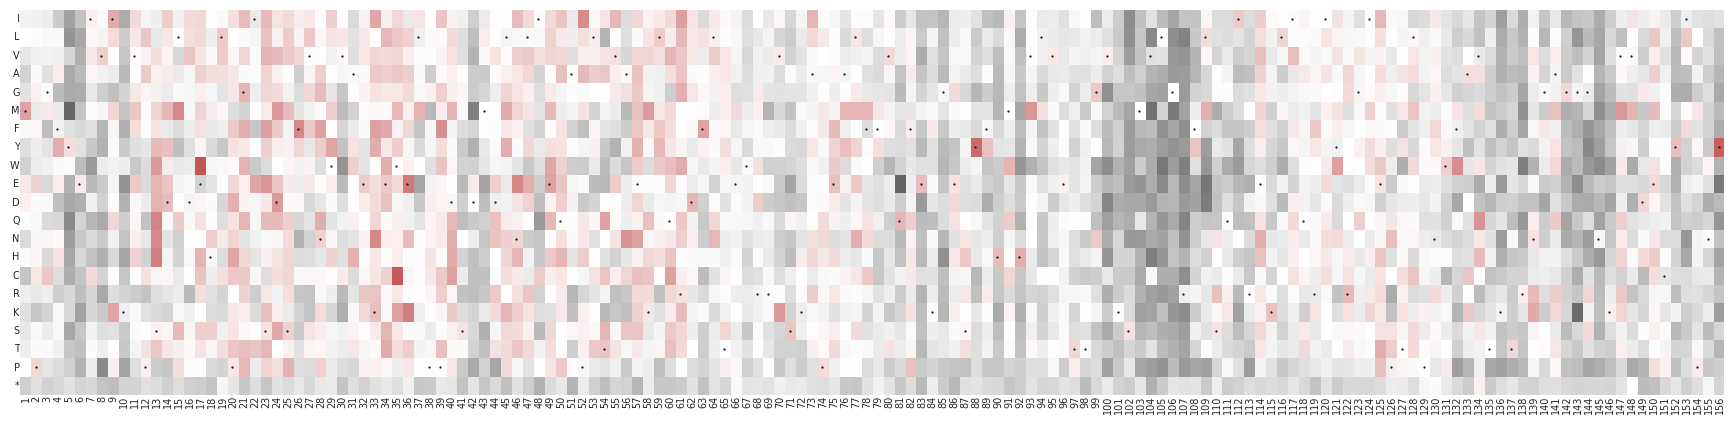

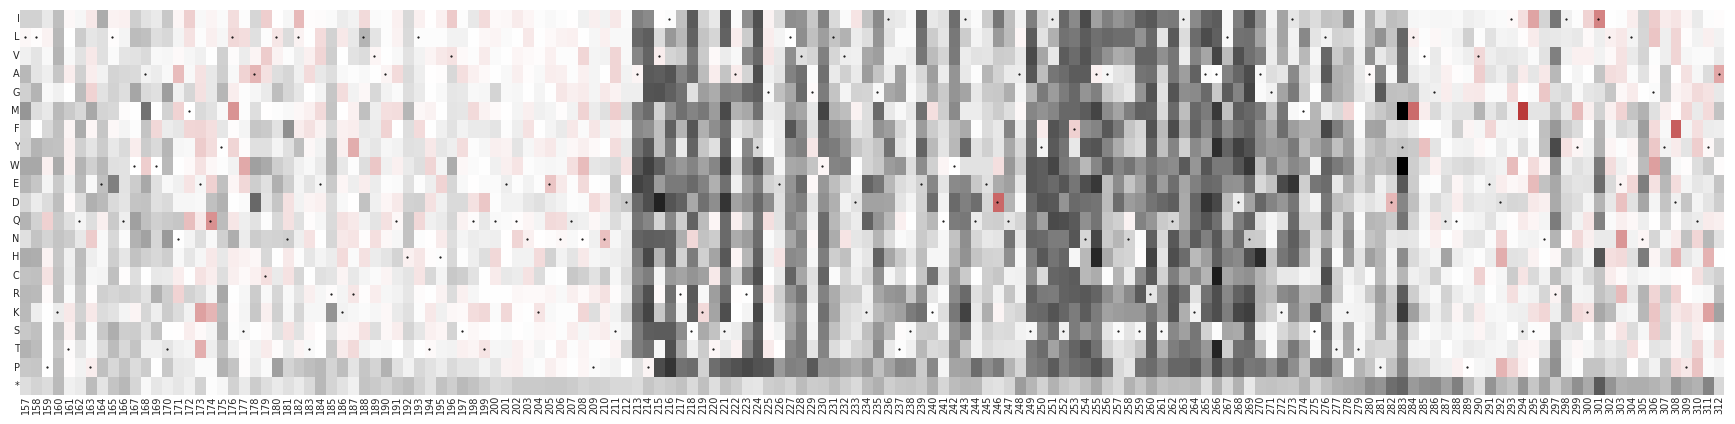

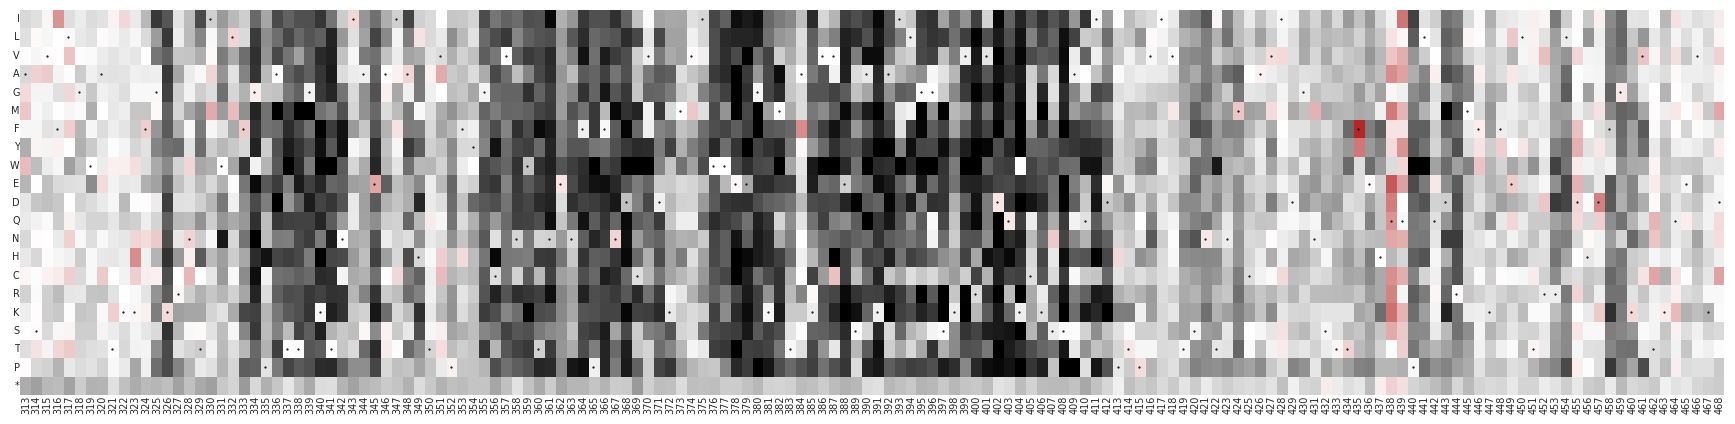

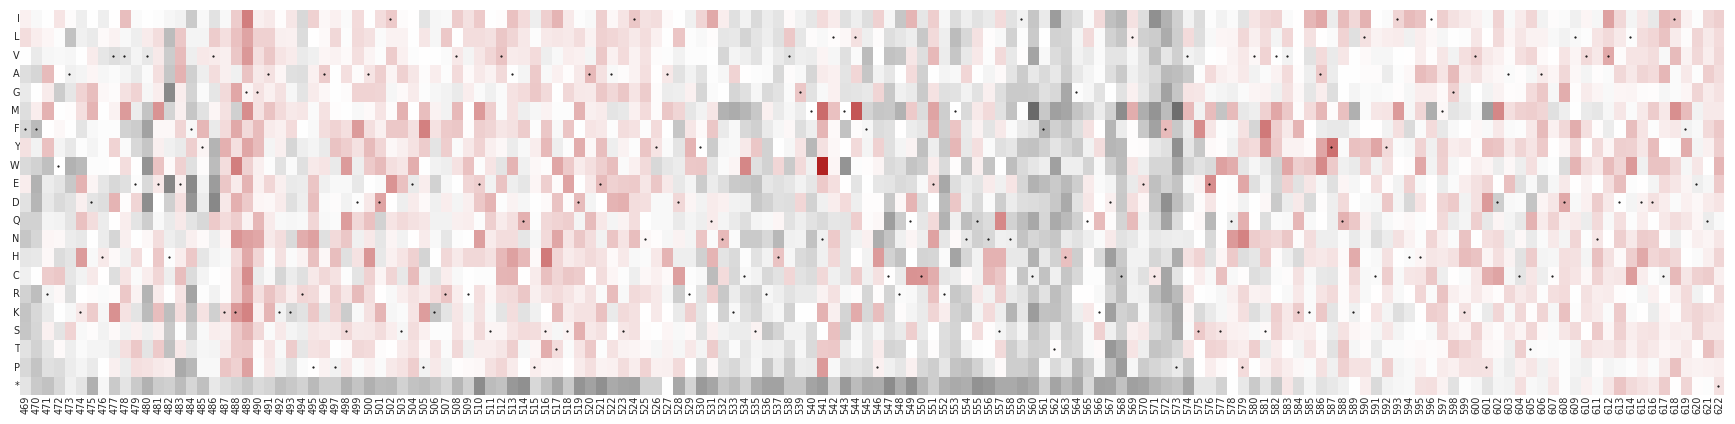

In [18]:
# Make aa level heatmaps using selection values from aav5 production assay
starting_pos = 1
while starting_pos < 470:
    if starting_pos > 468:
        end_pos = 623
    else:
        end_pos = starting_pos + 156
    plot_heatmap(aav5_selection_aa_trans_df, range_in=list(range(starting_pos,end_pos)), save=True,
                 save_name='aav5_aa_level_heatmap_pos' + str(starting_pos) + '-' + str(end_pos) + '.png',
                 dot_size=0.3, fig_dimensions=[22,5], plt_cbar=False, min_max=(-2.5, 1), text_size=7)
    starting_pos += 156

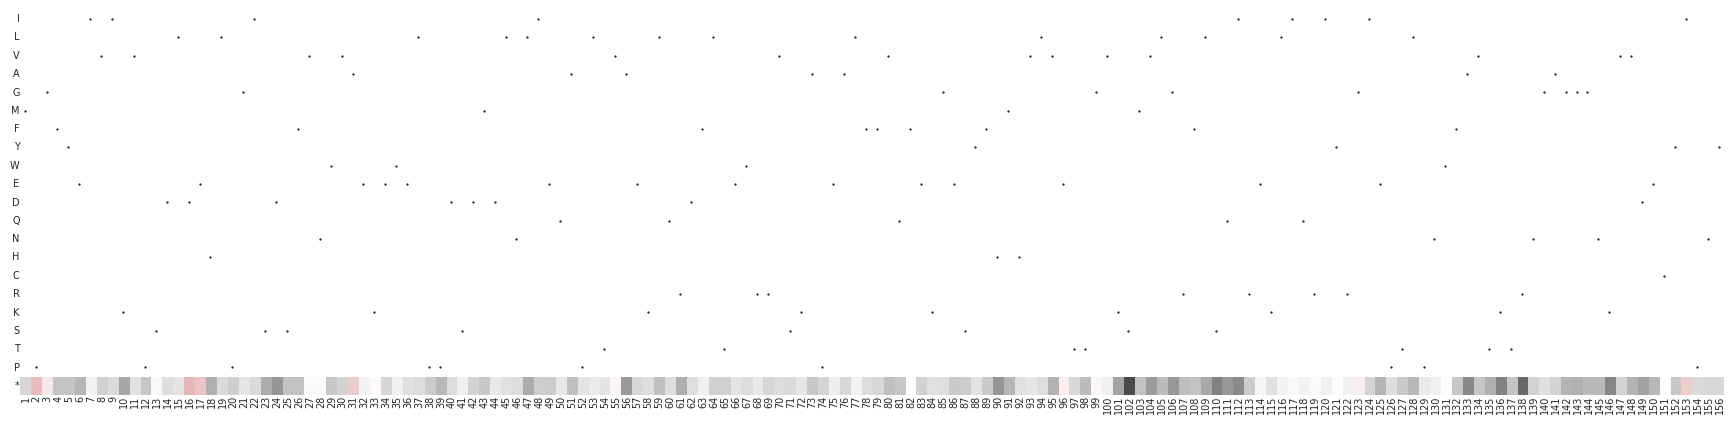

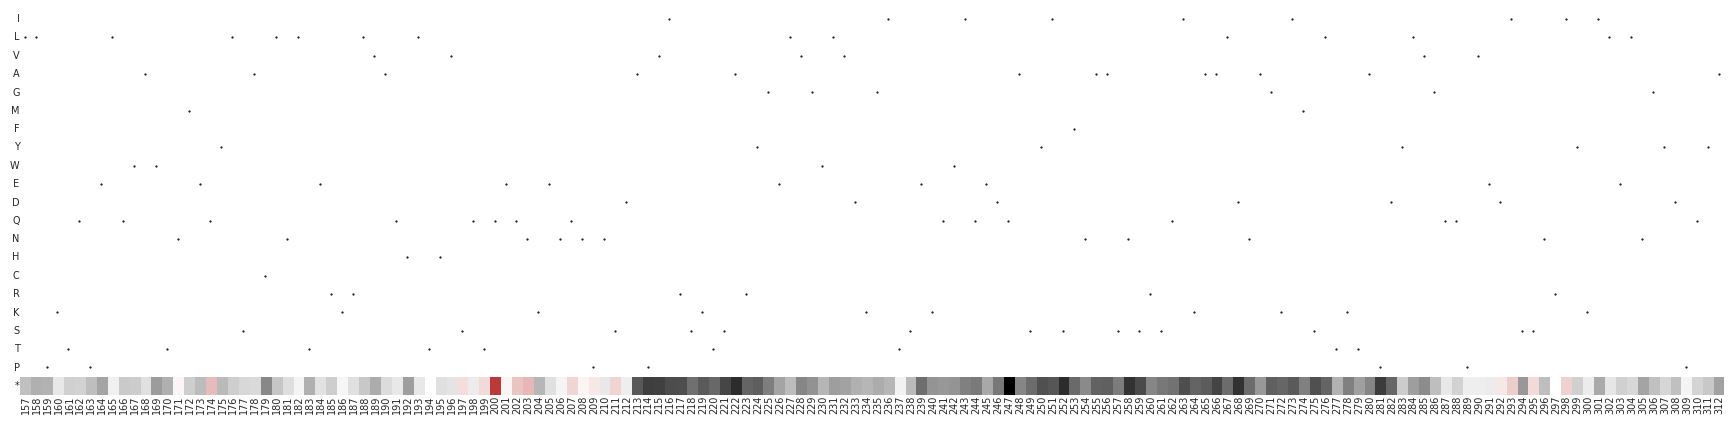

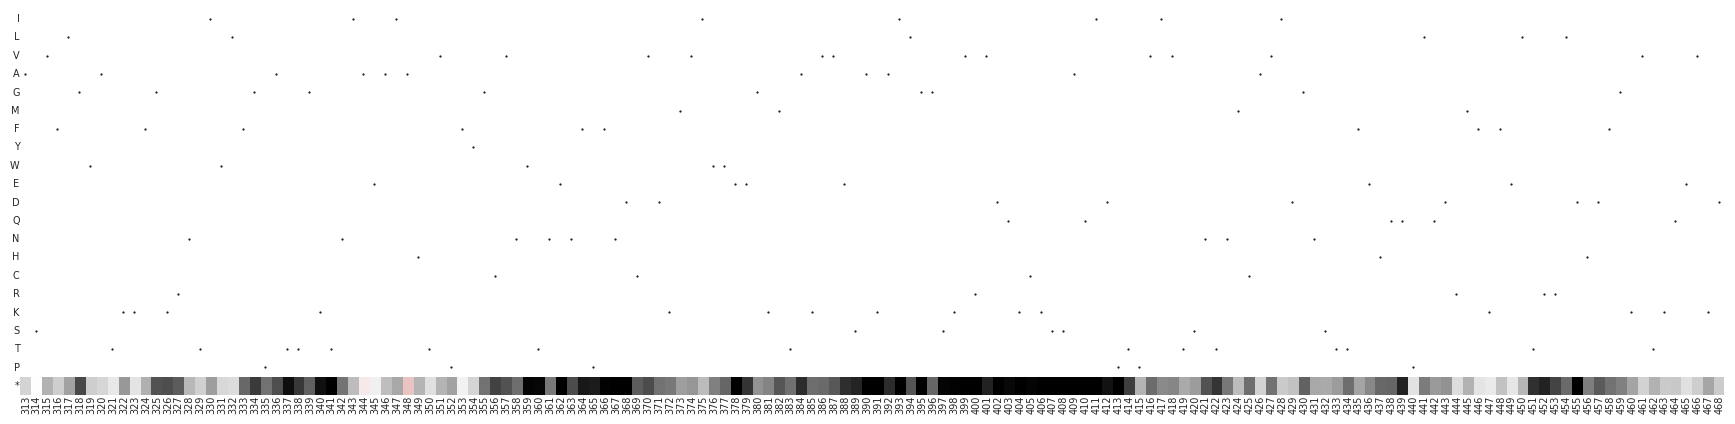

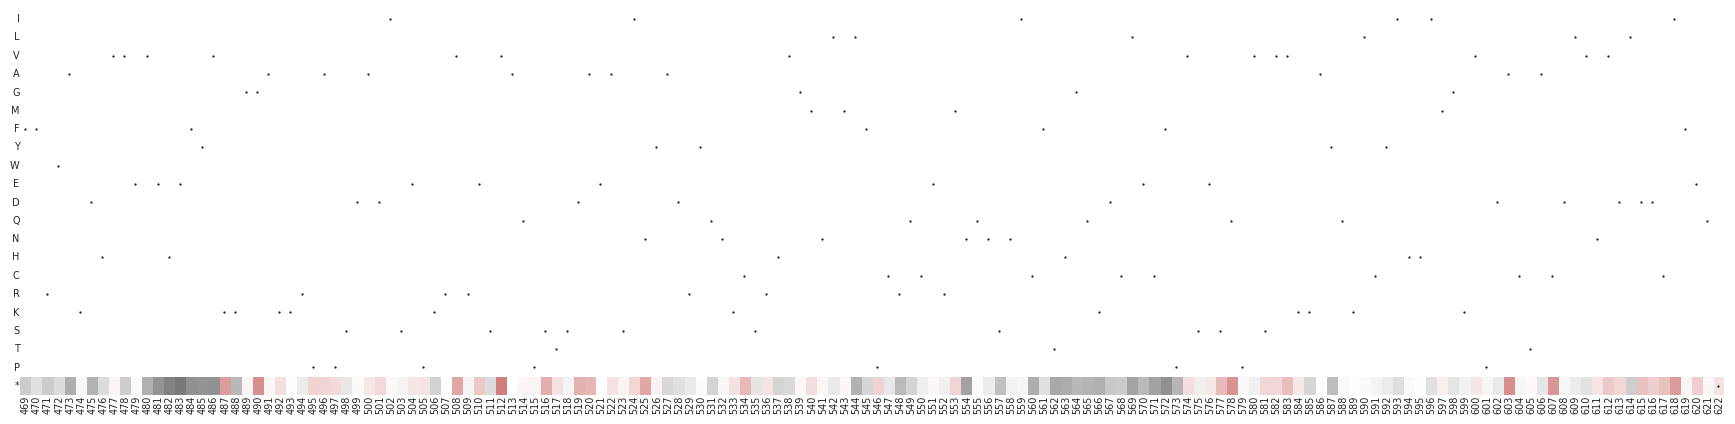

In [19]:
# Make aa level heatmaps using selection values from aav5 production assay for deletion variants
starting_pos = 1
while starting_pos < 470:
    if starting_pos > 468:
        end_pos = 623
    else:
        end_pos = starting_pos + 156
    plot_heatmap(aav5_selection_aa_trans_df, range_in=list(range(starting_pos,end_pos)), save=True, lib_type='del',
                 save_name='aav5_aa_level_heatmap_pos' + str(starting_pos) + '-' + str(end_pos) + '_del.png',
                 dot_size=0.3, fig_dimensions=[22,5], plt_cbar=False, min_max=(-2.5, 1), text_size=7)
    starting_pos += 156

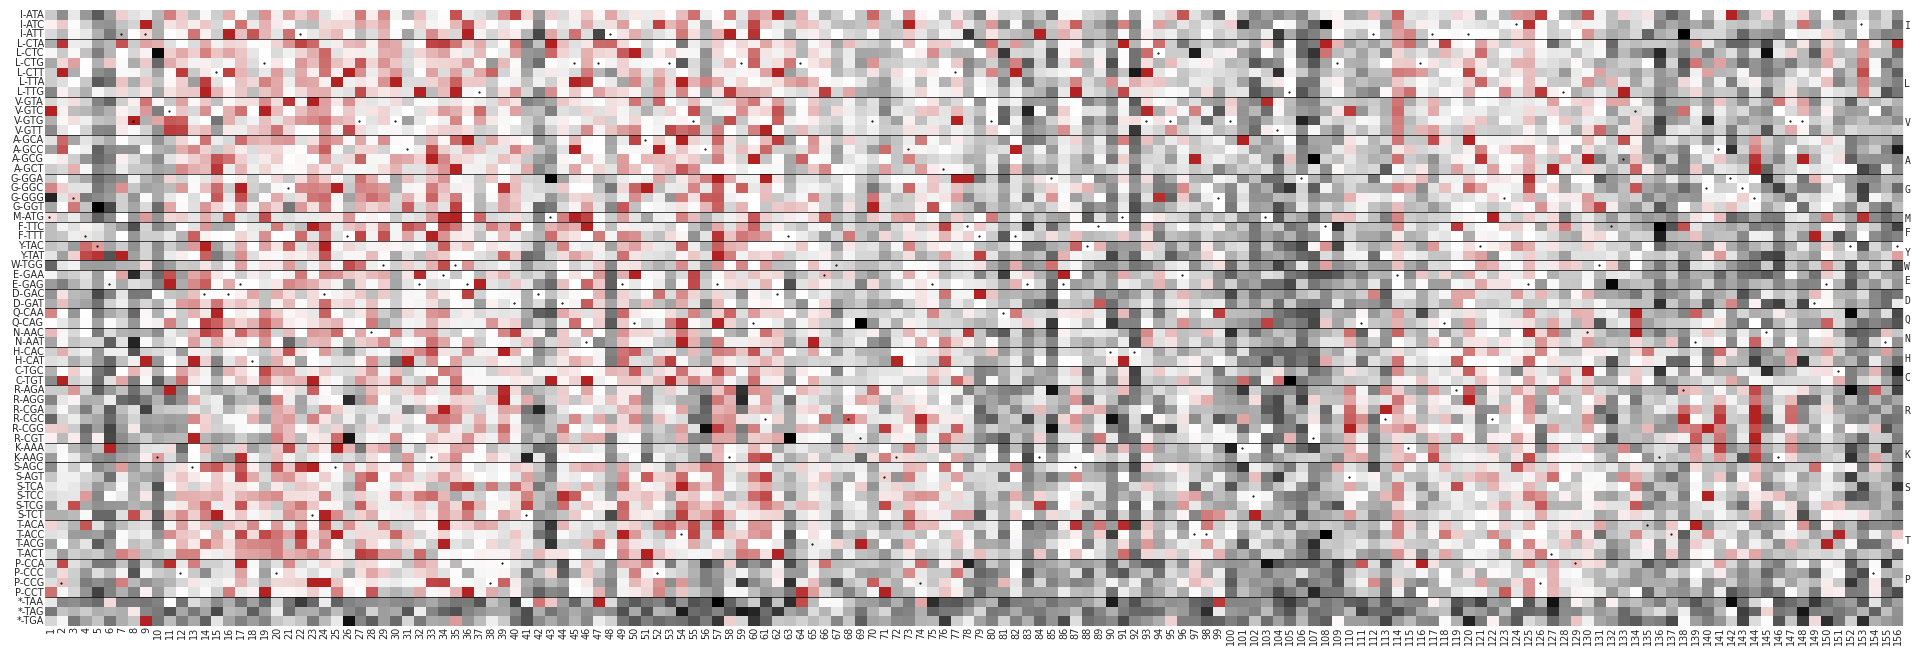

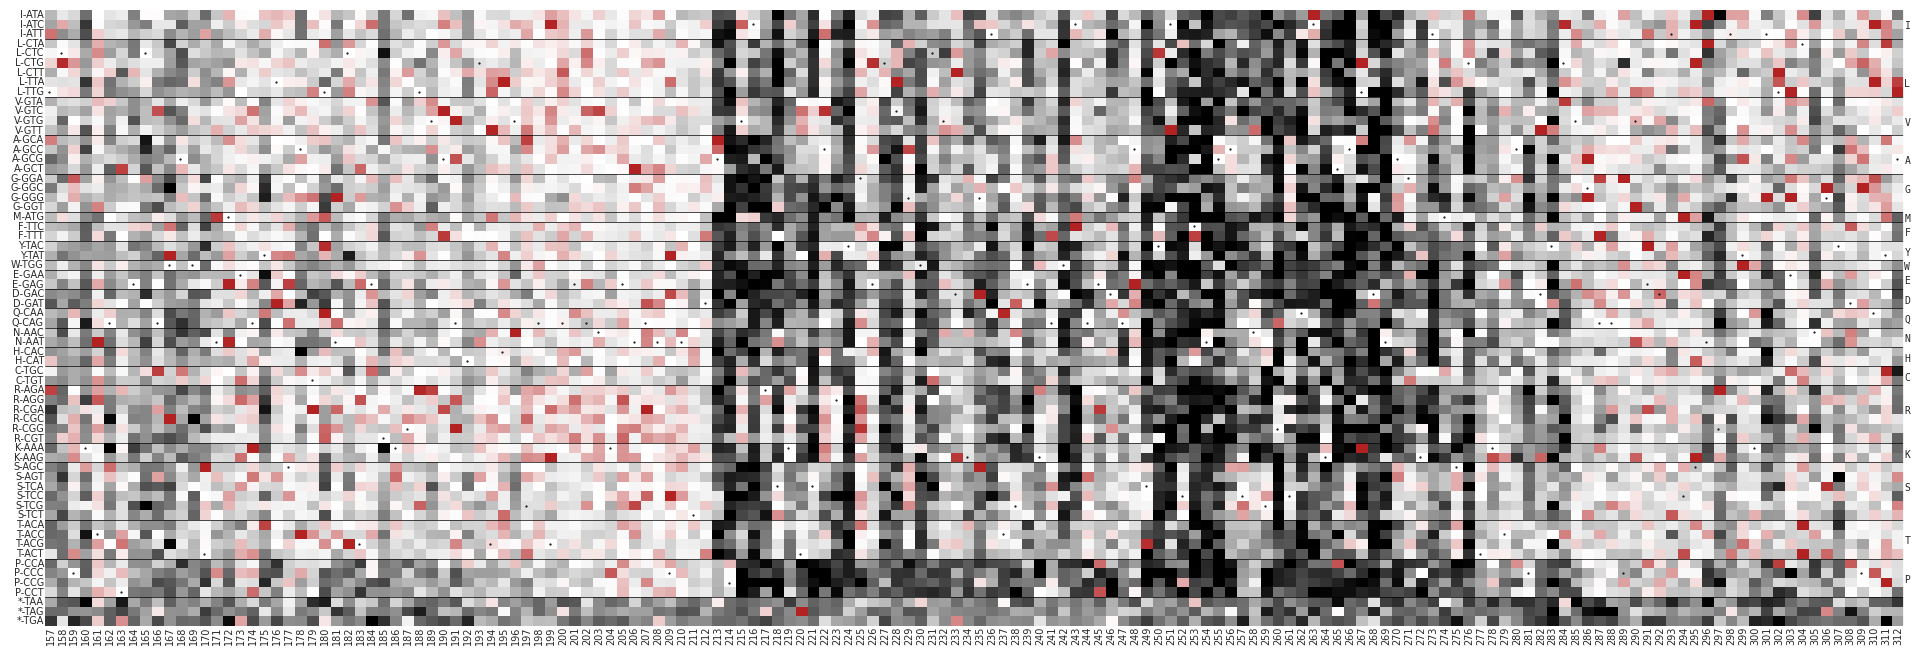

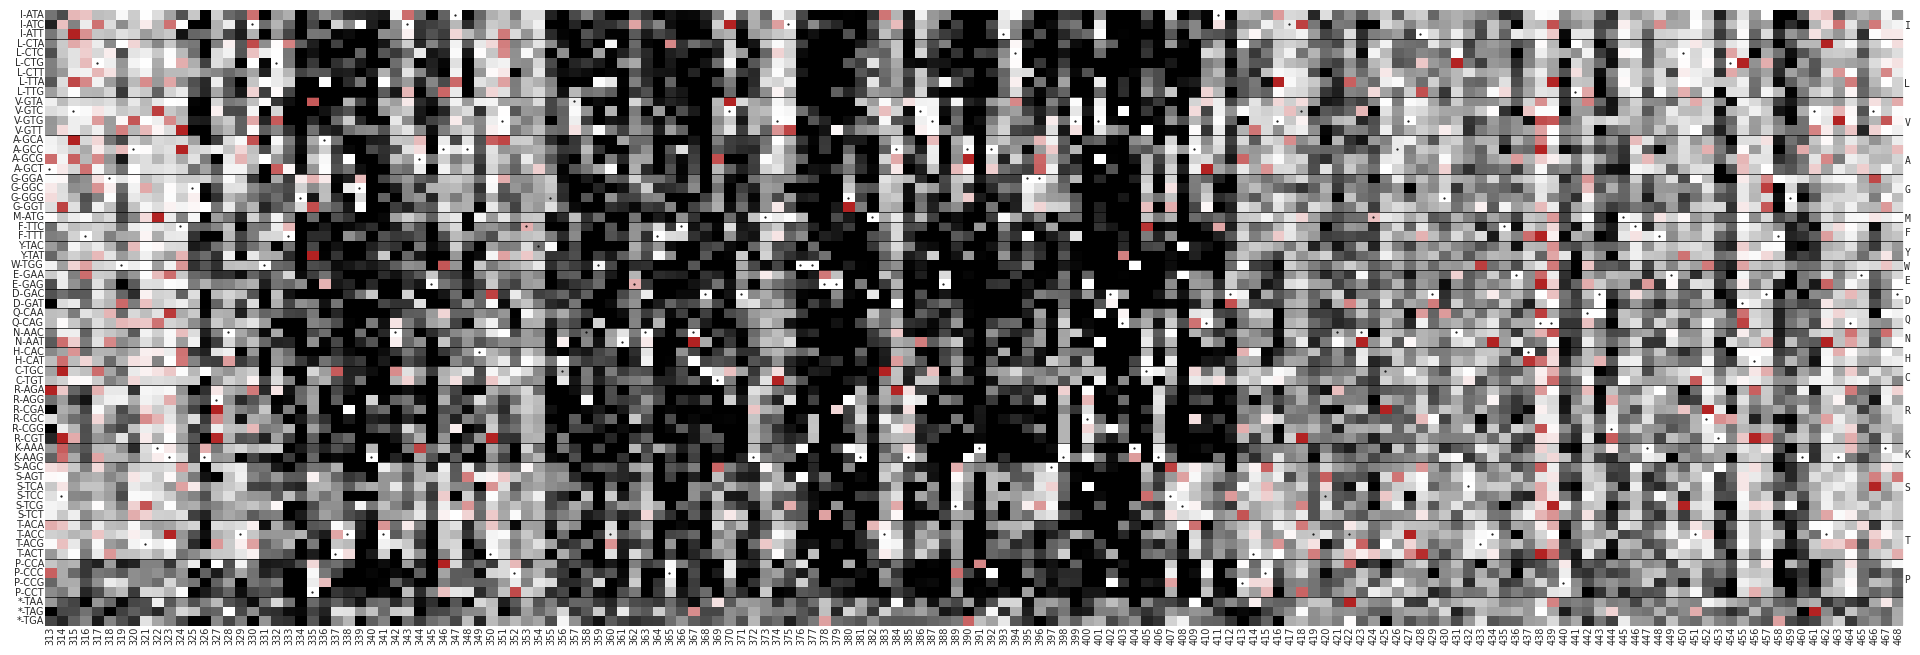

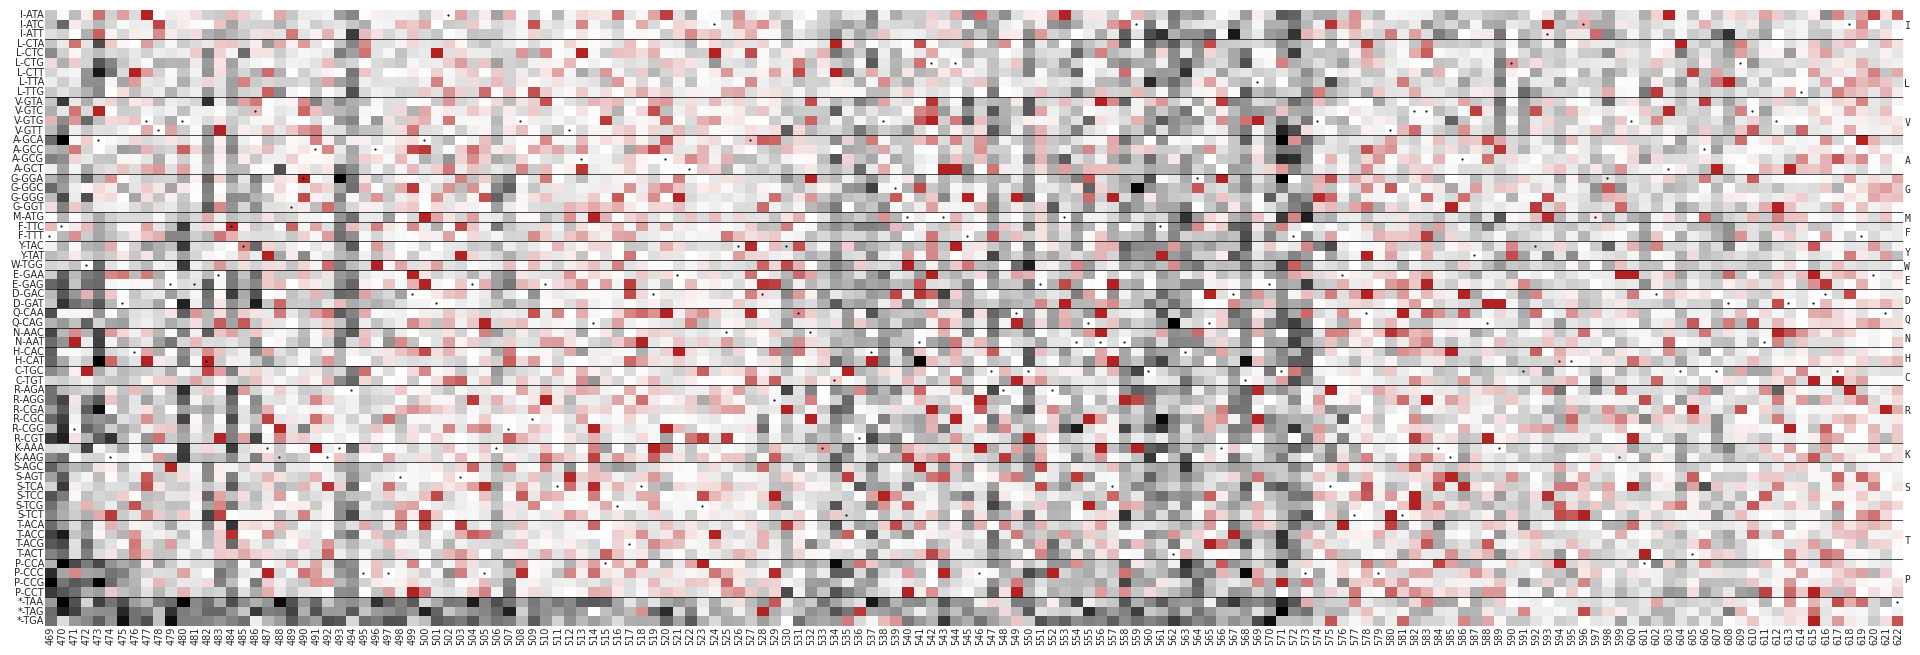

In [20]:
# Make codon level heatmaps using selection values from aav9 production assay
starting_pos = 1
while starting_pos < 470:
    if starting_pos > 468:
        end_pos = 623
    else:
        end_pos = starting_pos + 156
    plot_heatmap(aav9_selection_codon_trans_df, range_in=list(range(starting_pos,end_pos)), save=True,
                 save_name='aav9_codon_level_heatmap_pos' + str(starting_pos) + '-' + str(end_pos) + '.png',
                 dot_size=0.3, fig_dimensions=[24,8], plt_cbar=False, min_max=(-2.5, 1), text_size=7)
    starting_pos += 156

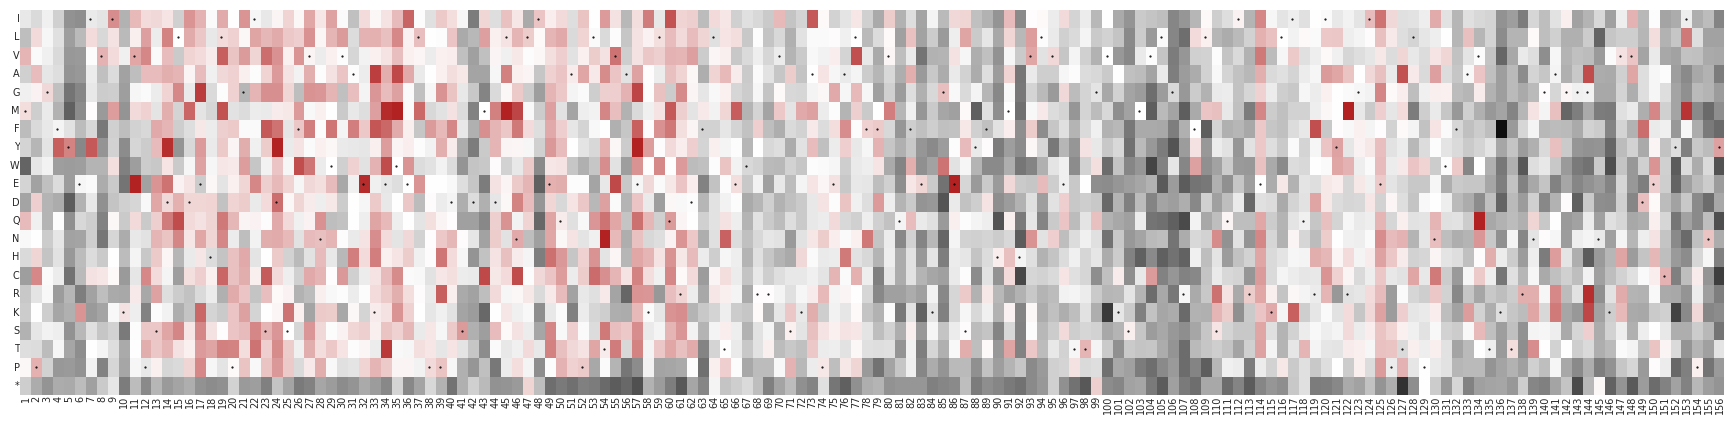

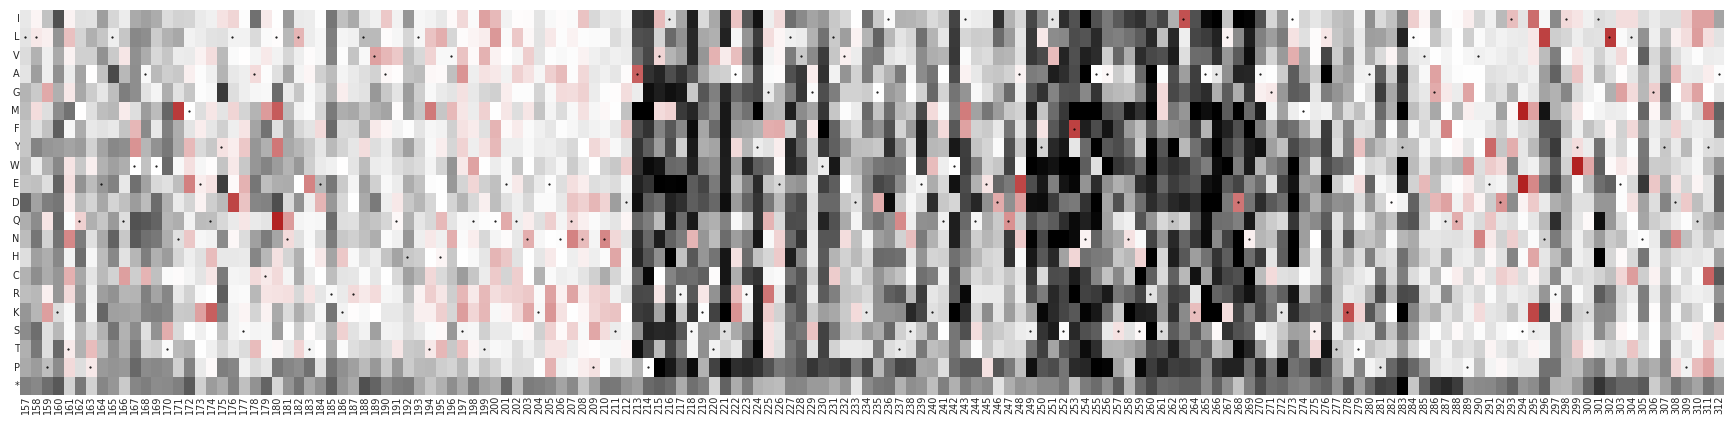

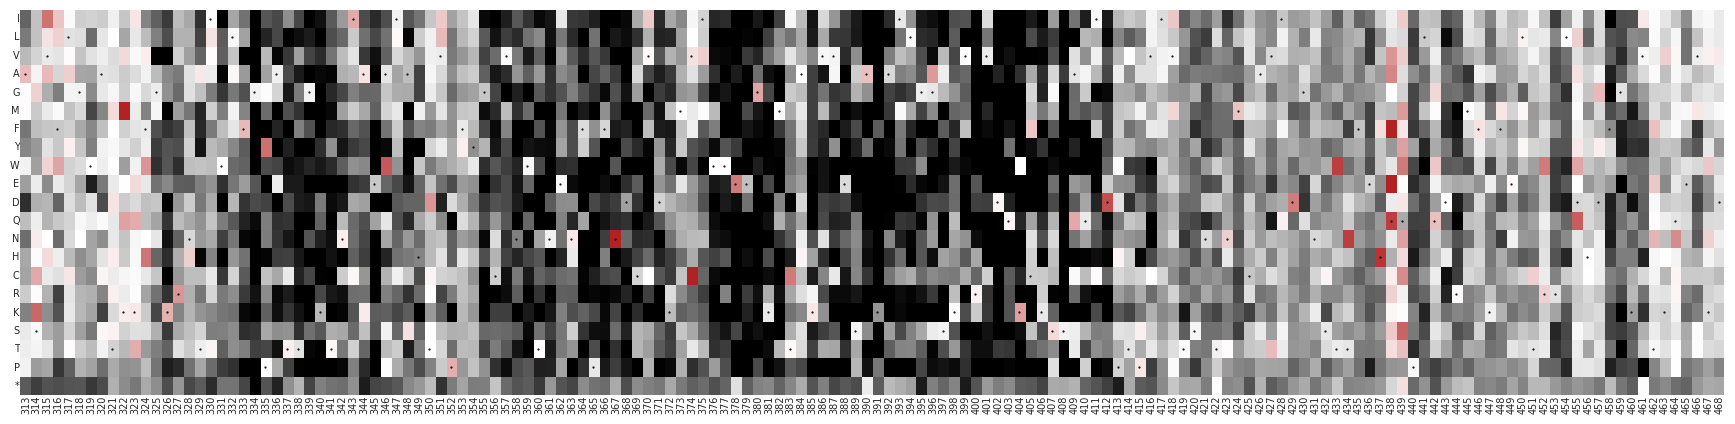

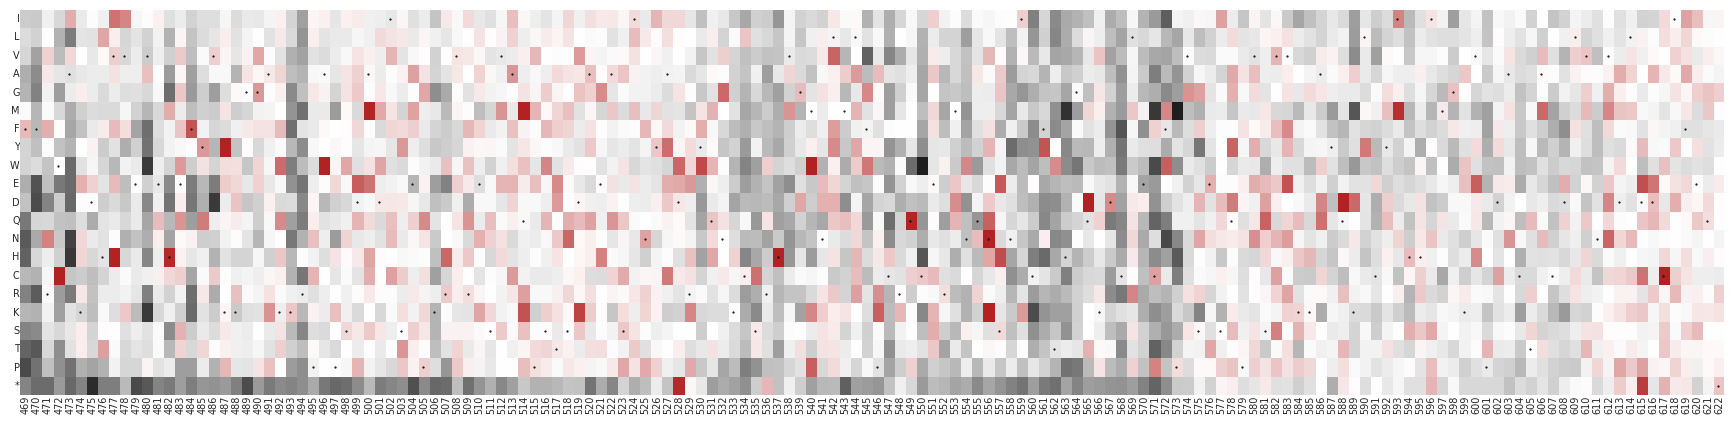

In [21]:
# Make aa level heatmaps using selection values from aav9 production assay
starting_pos = 1
while starting_pos < 470:
    if starting_pos > 468:
        end_pos = 623
    else:
        end_pos = starting_pos + 156
    plot_heatmap(aav9_selection_aa_trans_df, range_in=list(range(starting_pos,end_pos)), save=True,
                 save_name='aav9_aa_level_heatmap_pos' + str(starting_pos) + '-' + str(end_pos) + '.png',
                 dot_size=0.3, fig_dimensions=[22,5], plt_cbar=False, min_max=(-2.5, 1), text_size=7)
    starting_pos += 156

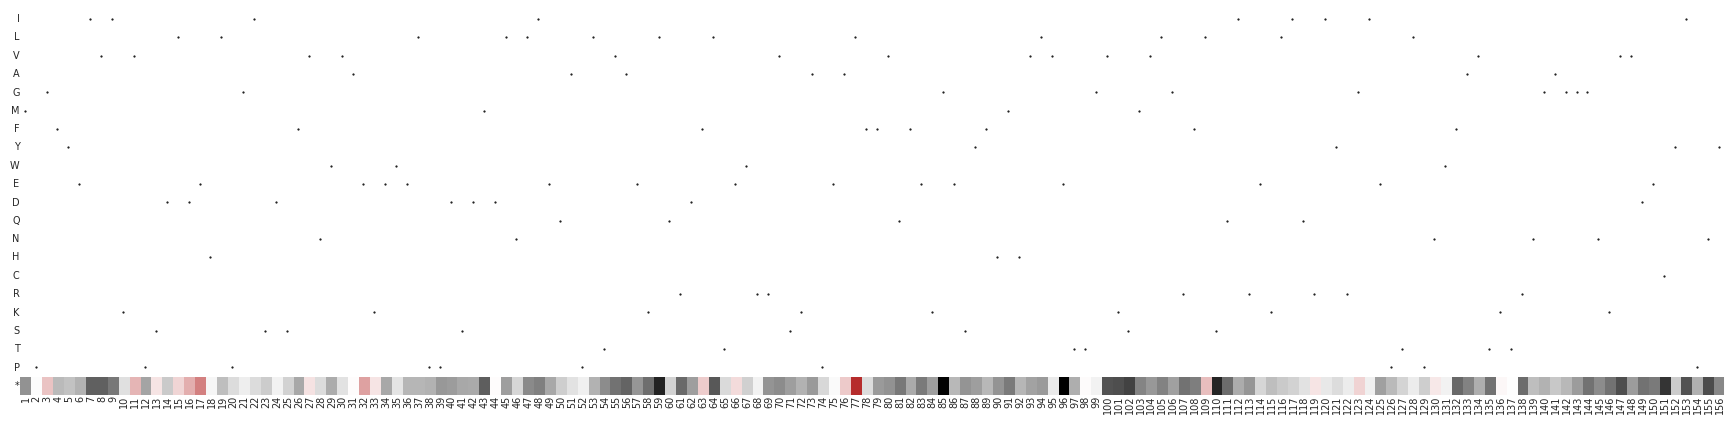

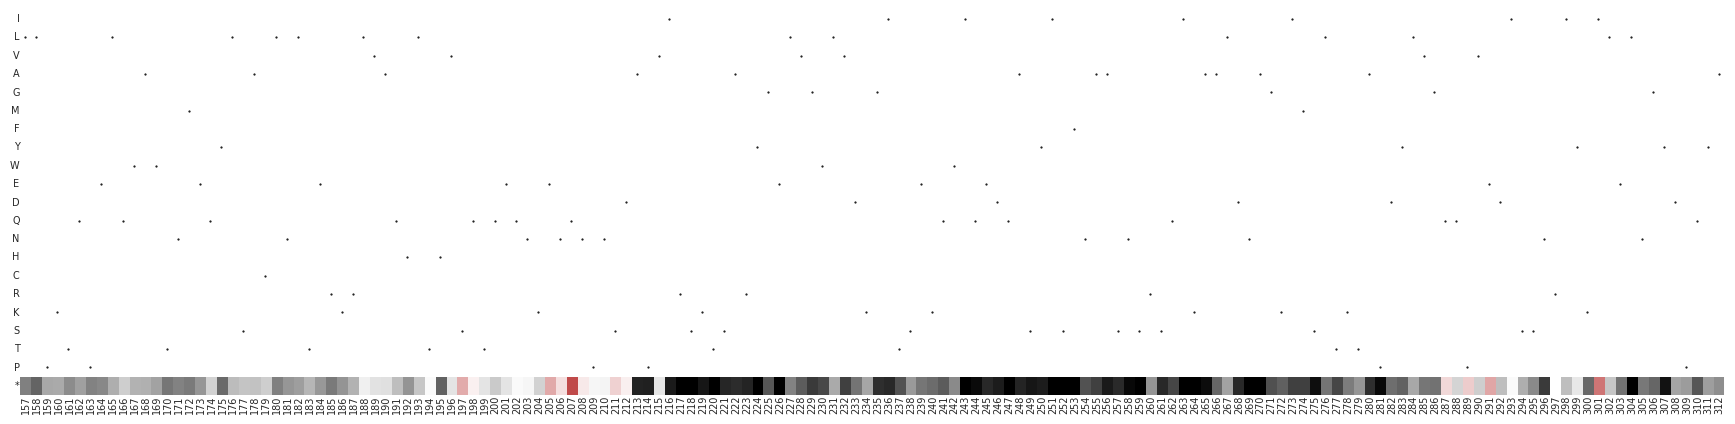

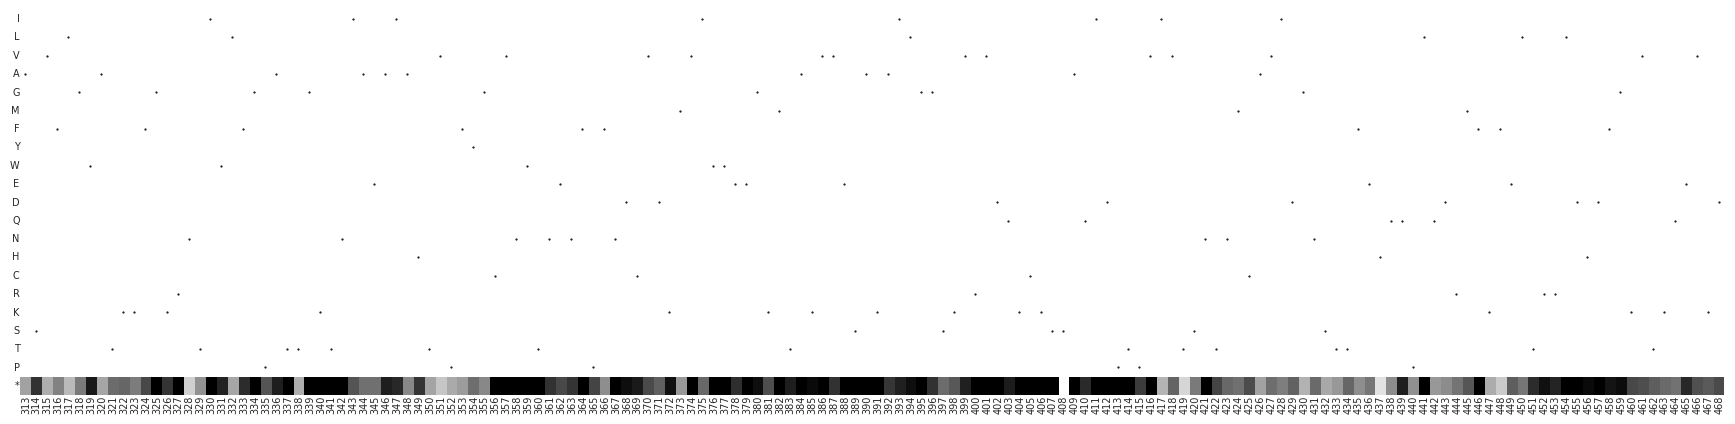

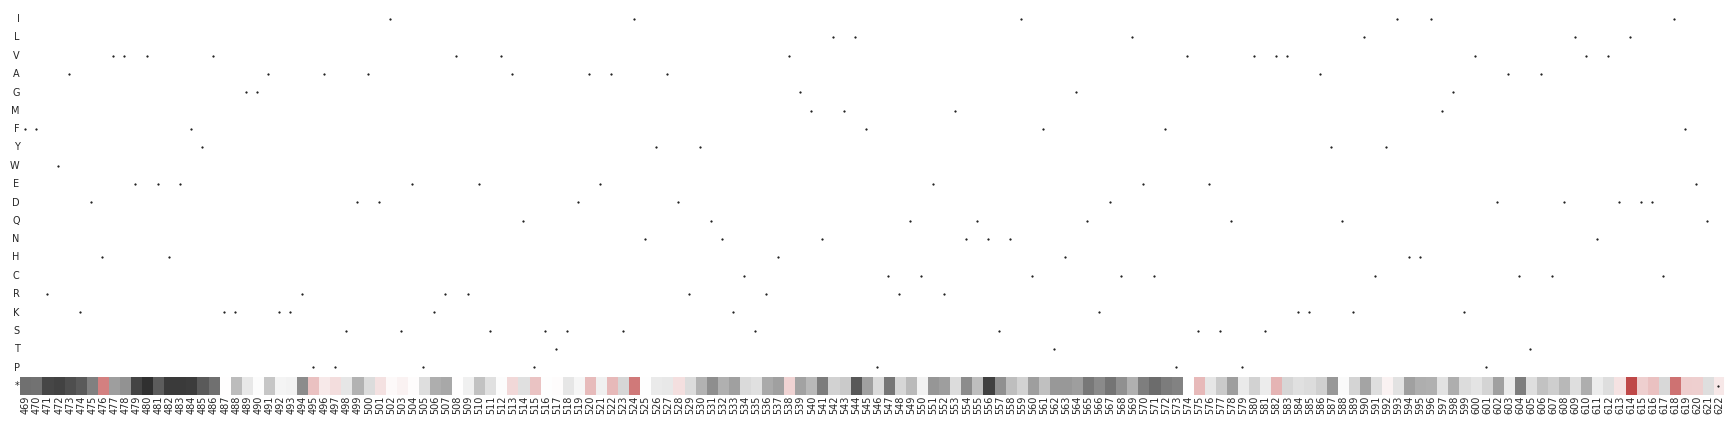

In [22]:
# Make aa level heatmaps using selection values from aav9 production assay for deletion variants
starting_pos = 1
while starting_pos < 470:
    if starting_pos > 468:
        end_pos = 623
    else:
        end_pos = starting_pos + 156
    plot_heatmap(aav9_selection_aa_trans_df, range_in=list(range(starting_pos,end_pos)), save=True, lib_type='del',
                 save_name='aav9_aa_level_heatmap_pos' + str(starting_pos) + '-' + str(end_pos) + '_del.png',
                 dot_size=0.3, fig_dimensions=[22,5], plt_cbar=False, min_max=(-2.5, 1), text_size=7)
    starting_pos += 156

In [23]:
# Generate WT_PLOTTING_DF to overlay heatmaps for wtaav2 library
standard_table = CodonTable.unambiguous_dna_by_name["Standard"]
codon_dict = standard_table.forward_table
# Add stop codons
codon_dict['TAA'] = '*'
codon_dict['TAG'] = '*'
codon_dict['TGA'] = '*'
codons = codon_dict.keys()

wt_rep = 'ATGCCGGGGTTTTACGAGATTGTGATTAAGGTCCCCAGCGACCTTGACGAGCATCTGCCCGGCATTTCTGACAGCTTTGTGAACTGGGTGGCCGAGAAGGAATGGGAGTTGCCGCCAGATTCTGACATGGATCTGAATCTGATTGAGCAGGCACCCCTGACCGTGGCCGAGAAGCTGCAGCGCGACTTTCTGACGGAATGGCGCCGTGTGAGTAAGGCCCCGGAGGCCCTTTTCTTTGTGCAATTTGAGAAGGGAGAGAGCTACTTCCACATGCACGTGCTCGTGGAAACCACCGGGGTGAAATCCATGGTTTTGGGACGTTTCCTGAGTCAGATTCGCGAAAAACTGATTCAGAGAATTTACCGCGGGATCGAGCCGACTTTGCCAAACTGGTTCGCGGTCACAAAGACCAGAAATGGCGCCGGAGGCGGGAACAAGGTGGTGGATGAGTGCTACATCCCCAATTACTTGCTCCCCAAAACCCAGCCTGAGCTCCAGTGGGCGTGGACTAATATGGAACAGTATTTAAGCGCCTGTTTGAATCTCACGGAGCGTAAACGGTTGGTGGCGCAGCATCTGACGCACGTGTCGCAGACGCAGGAGCAGAACAAAGAGAATCAGAATCCCAATTCTGATGCGCCGGTGATCAGATCAAAAACTTCAGCCAGGTACATGGAGCTGGTCGGGTGGCTCGTGGACAAGGGGATTACCTCGGAGAAGCAGTGGATCCAGGAGGACCAGGCCTCATACATCTCCTTCAATGCGGCCTCCAACTCGCGGTCCCAAATCAAGGCTGCCTTGGACAATGCGGGAAAGATTATGAGCCTGACTAAAACCGCCCCCGACTACCTGGTGGGCCAGCAGCCCGTGGAGGACATTTCCAGCAATCGGATTTATAAAATTTTGGAACTAAACGGGTACGATCCCCAATATGCGGCTTCCGTCTTTCTGGGATGGGCCACGAAAAAGTTCGGCAAGAGGAACACCATCTGGCTGTTTGGGCCTGCAACTACCGGCAAGACCAACATCGCGGAGGCCATAGCCCACACTGTGCCCTTCTACGGGTGCGTAAACTGGACCAATGAGAACTTTCCCTTCAACGACTGTGTCGACAAGATGGTGATCTGGTGGGAGGAGGGGAAGATGACCGCCAAGGTCGTGGAGTCGGCCAAAGCCATTCTCGGAGGAAGCAAGGTGCGCGTGGACCAGAAATGCAAGTCCTCGGCCCAGATAGACCCGACTCCCGTGATCGTCACCTCCAACACCAACATGTGCGCCGTGATTGACGGGAACTCAACGACCTTCGAACACCAGCAGCCGTTGCAAGACCGGATGTTCAAATTTGAACTCACCCGCCGTCTGGATCATGACTTTGGGAAGGTCACCAAGCAGGAAGTCAAAGACTTTTTCCGGTGGGCAAAGGATCACGTGGTTGAGGTGGAGCATGAATTCTACGTCAAAAAGGGTGGAGCCAAGAAAAGACCCGCCCCCAGTGACGCAGATATAAGTGAGCCCAAACGGGTGCGCGAGTCAGTTGCGCAGCCATCGACGTCAGACGCGGAAGCTTCGATCAACTACGCAGACAGGTACCAAAACAAATGTTCTCGTCACGTGGGCATGAATCTGATGCTGTTTCCCTGCAGACAATGCGAGAGAATGAATCAGAATTCAAATATCTGCTTCACTCACGGACAGAAAGACTGTTTAGAGTGCTTTCCCGTGTCAGAATCTCAACCCGTTTCTGTCGTCAAAAAGGCGTATCAGAAACTGTGCTACATTCATCATATCATGGGAAAGGTGCCAGACGCTTGCACTGCCTGCGATCTGGTCAATGTGGATTTGGATGACTGCATCTTTGAACAATAA'
WT_PLOTTING_DF = pd.DataFrame(columns=['aa', 'abs_pos', 'codon', 'wt'])
nt = 0
abs_pos = 1
while nt < len(wt_rep) - 3:
#     print (wt_rep[nt:nt+3])
    codon = wt_rep[nt:nt+3]
    aa = codon_dict[codon]
    row_dict = {'aa':[aa], 'abs_pos':[abs_pos], 'codon':[codon], 'wt': [1]}
    new_row = pd.DataFrame(row_dict)
    WT_PLOTTING_DF = pd.concat([WT_PLOTTING_DF,new_row])
#     print (new_row)
    abs_pos += 1
    nt += 3

# WT_PLOTTING_DF.reset_index()
WT_PLOTTING_DF.head()

,aa,abs_pos,codon,wt
0,M,1,ATG,1
0,P,2,CCG,1
0,G,3,GGG,1
0,F,4,TTT,1
0,Y,5,TAC,1


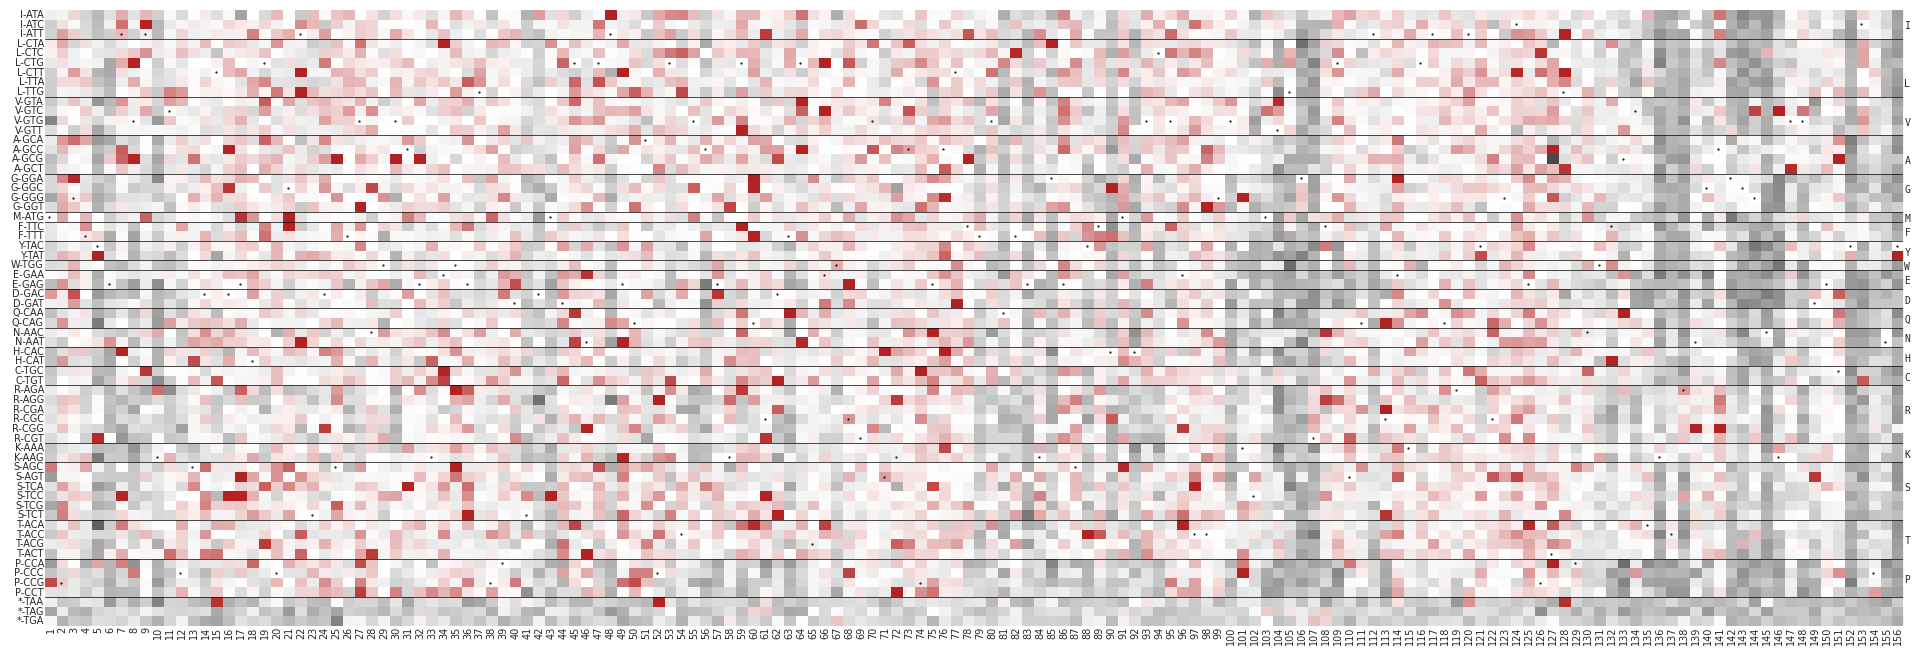

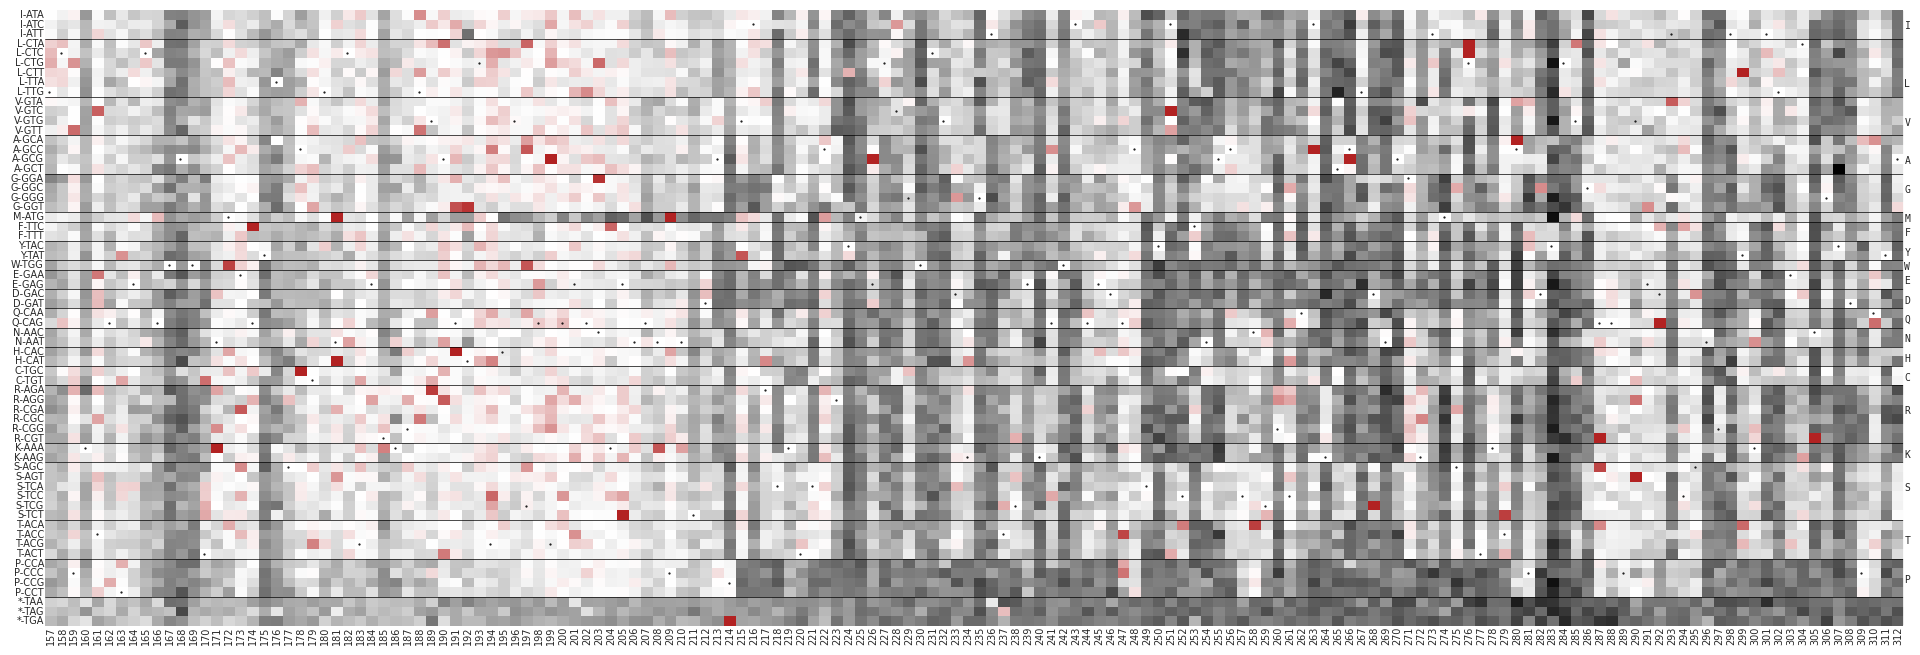

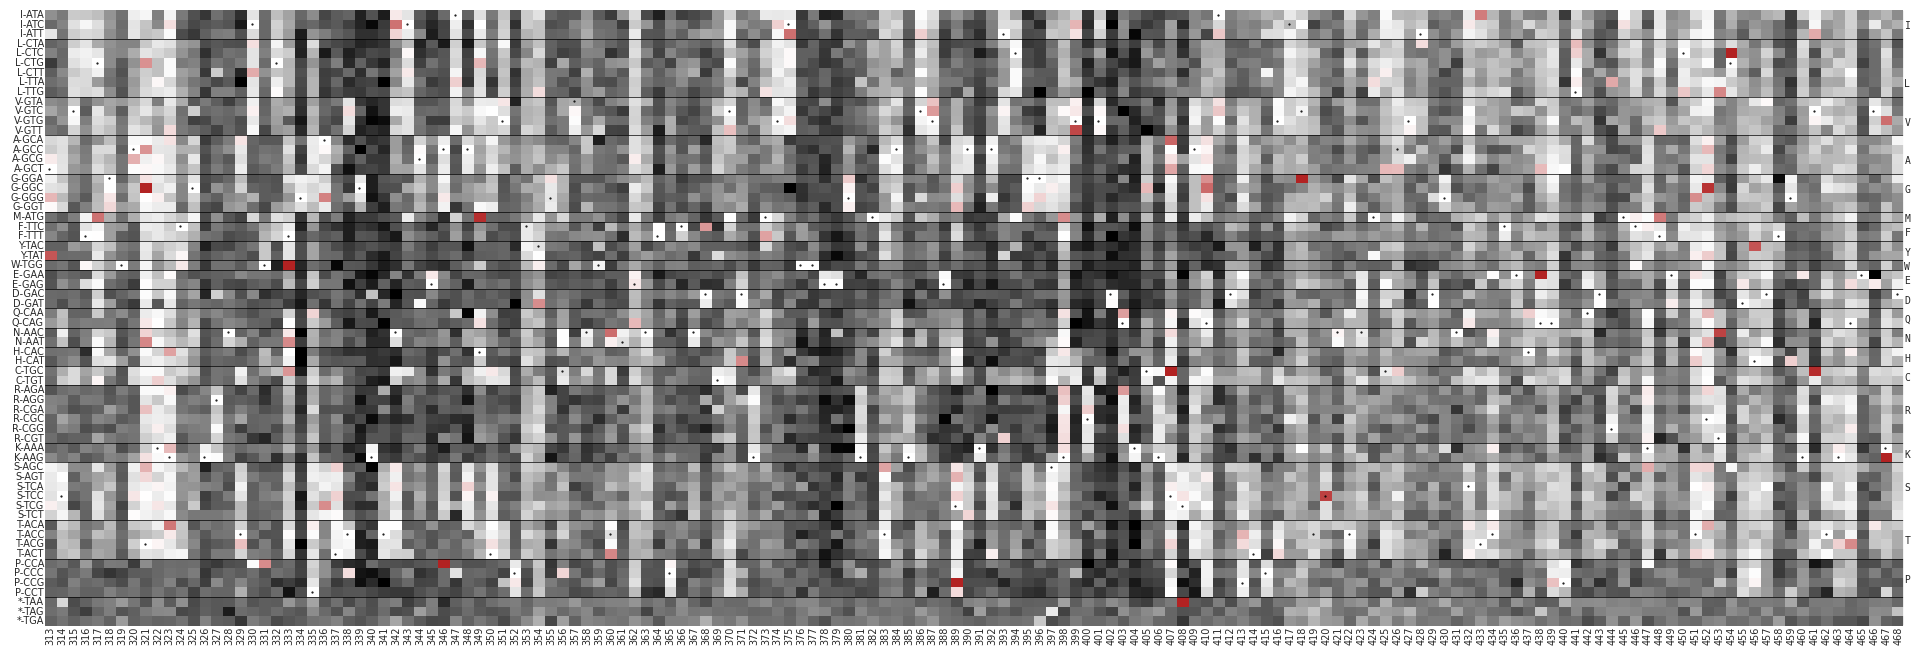

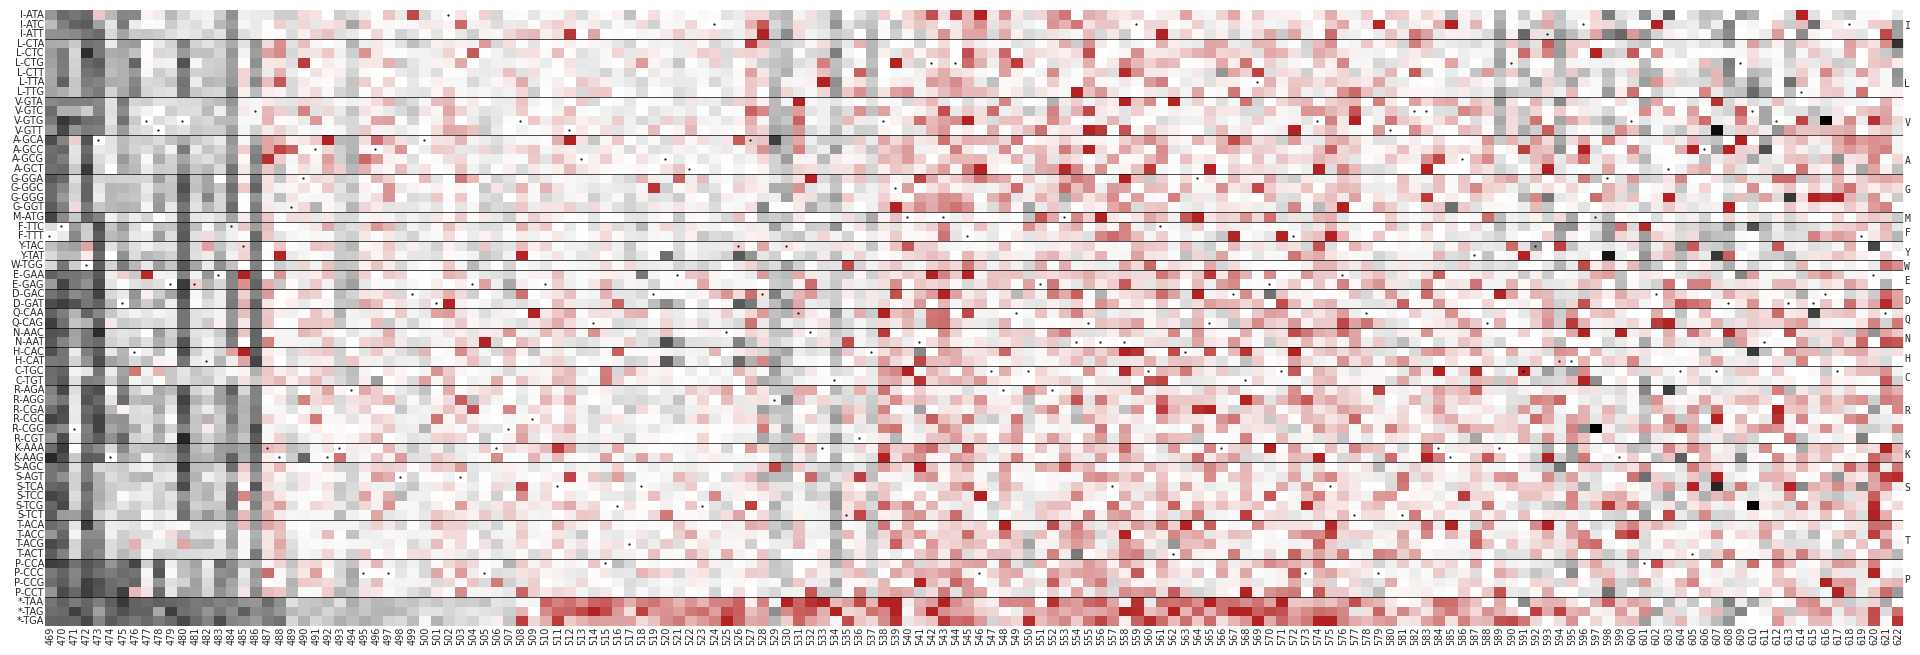

In [24]:
# Make codon level heatmaps using selection values from wtaav2 production assay
starting_pos = 1
while starting_pos < 470:
    if starting_pos > 468:
        end_pos = 623
    else:
        end_pos = starting_pos + 156
    plot_heatmap(wtaav2_selection_codon_trans_df, range_in=list(range(starting_pos,end_pos)), save=True,
                 save_name='wtaav2_codon_level_heatmap_pos' + str(starting_pos) + '-' + str(end_pos) + '.png',
                 dot_size=0.3, fig_dimensions=[24,8], plt_cbar=False, min_max=(-2.5, 1), text_size=7)
    starting_pos += 156

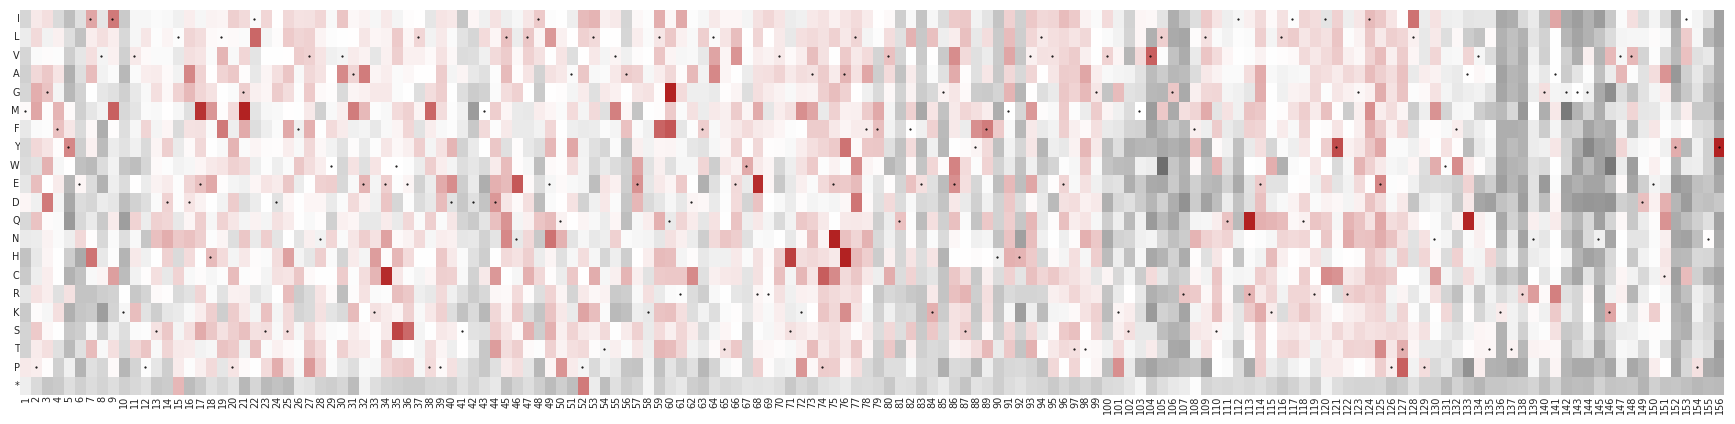

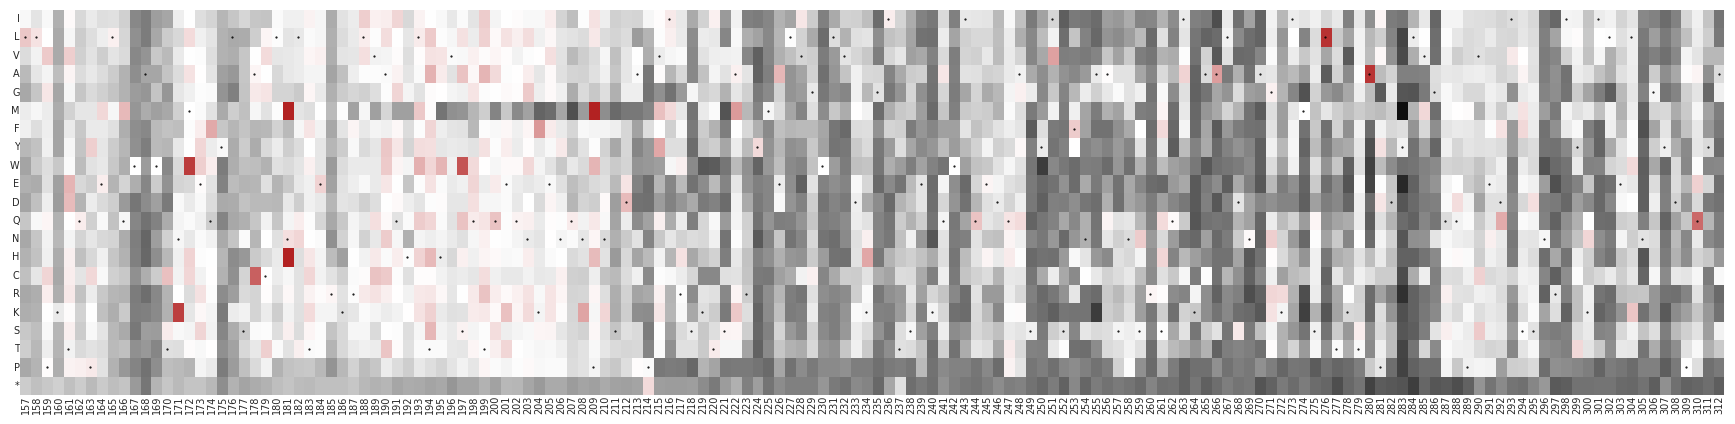

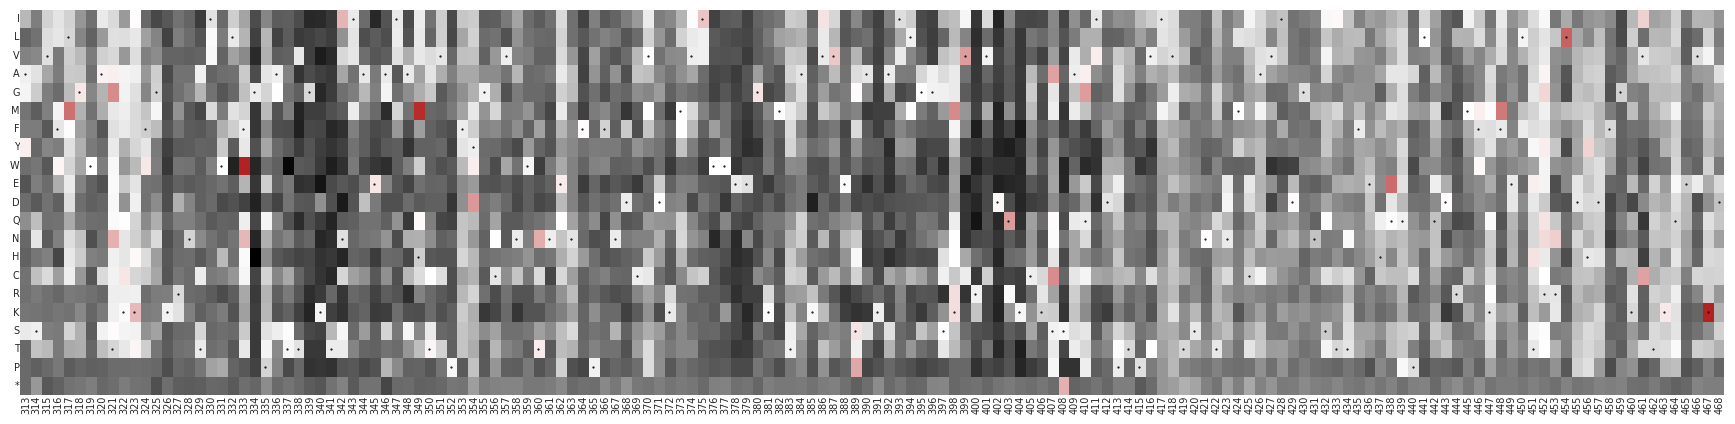

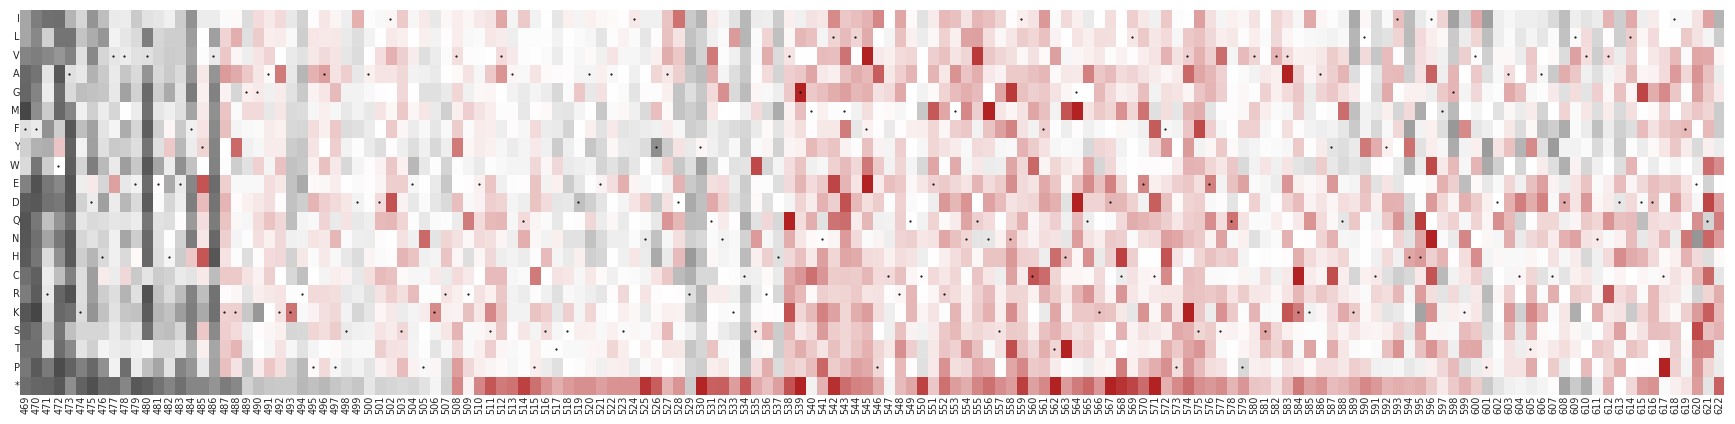

In [32]:
# Make aa level heatmaps using selection values from wtaav2 production assay
starting_pos = 1
while starting_pos < 470:
    if starting_pos > 468:
        end_pos = 623
    else:
        end_pos = starting_pos + 156
    plot_heatmap(wtaav2_selection_aa_trans_df, range_in=list(range(starting_pos,end_pos)), save=True,
                 save_name='wtaav2_aa_level_heatmap_pos' + str(starting_pos) + '-' + str(end_pos) + '.png',
                 dot_size=0.3, fig_dimensions=[22,5], plt_cbar=False, min_max=(-2.5, 1), text_size=7)
    starting_pos += 156

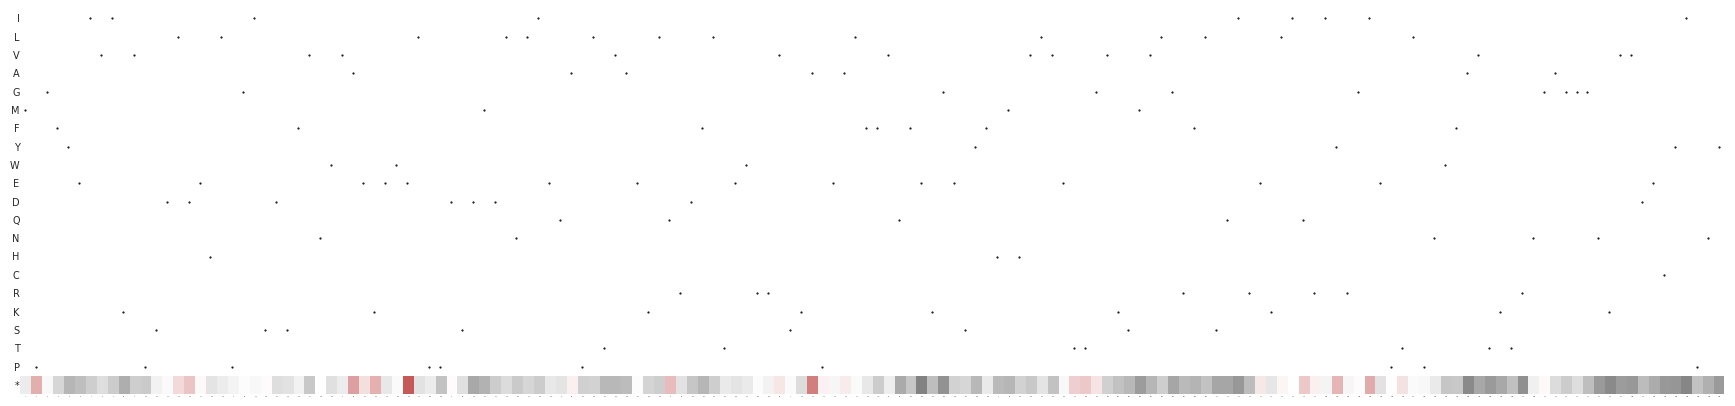

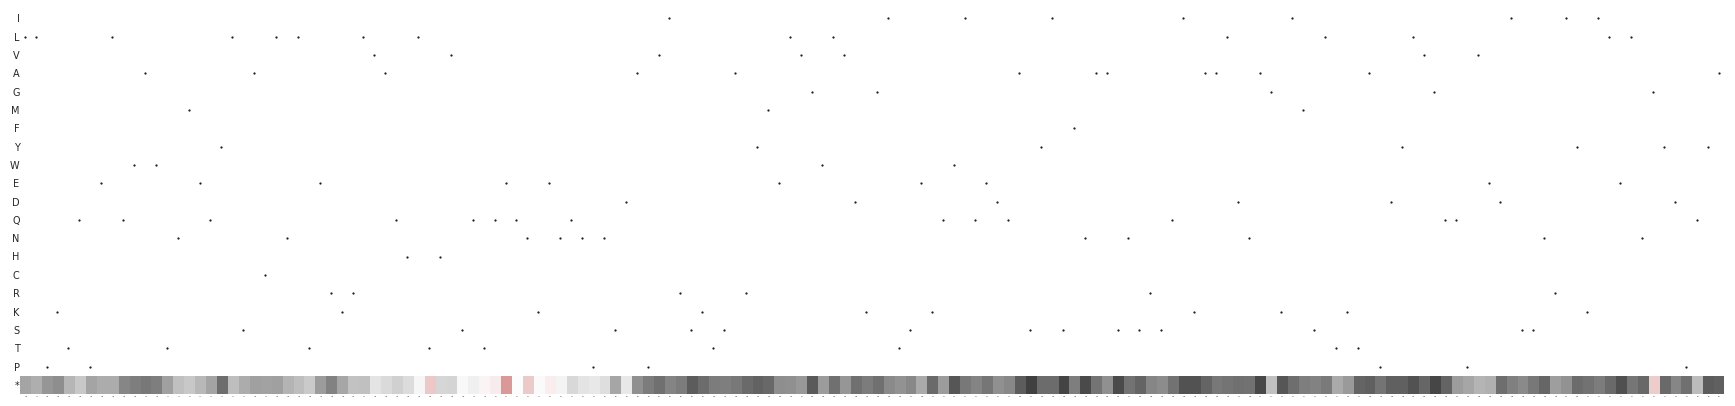

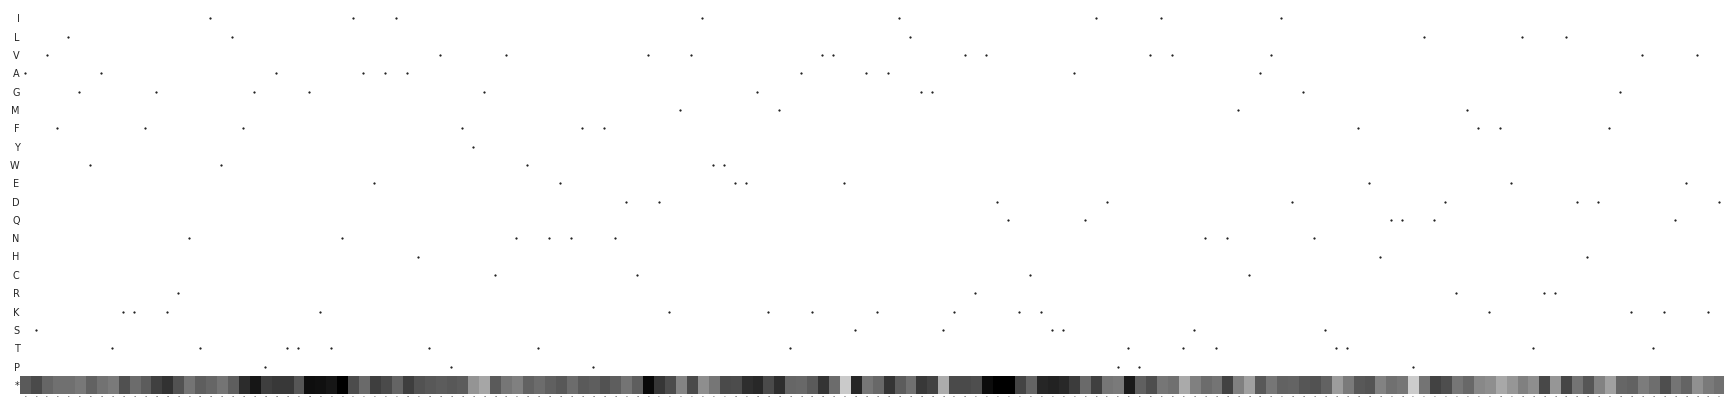

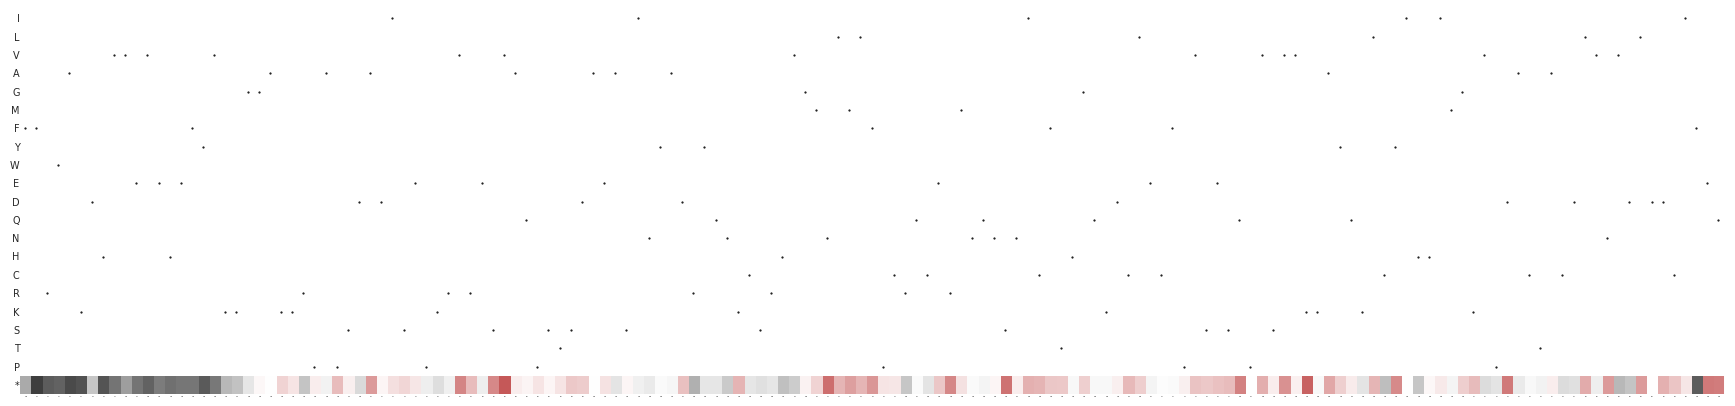

In [34]:
# Make aa level heatmaps using selection values from wtaav2 production assay for deletion variants
starting_pos = 1
while starting_pos < 470:
    if starting_pos > 468:
        end_pos = 623
    else:
        end_pos = starting_pos + 156
    plot_heatmap(wtaav2_selection_aa_trans_df, range_in=list(range(starting_pos,end_pos)), save=True, lib_type='del',
                 save_name='wtaav2_aa_level_heatmap_pos' + str(starting_pos) + '-' + str(end_pos) + '_del.png',
                 dot_size=0.3, fig_dimensions=[22,5], plt_cbar=False, min_max=(-2.5, 1), text_size=7)
    starting_pos += 156